<a href="https://colab.research.google.com/github/Gwme13/Multi-Task-Learning_with_PyTorch/blob/main/MTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Task Learning (MTL) vs. Single-Task Learning (STL) for Image Classification on CIFAR-10

This notebook explores and compares Multi-Task Learning (MTL) and Single-Task Learning (STL) approaches for image classification using the CIFAR-10 dataset. We will utilize AlexNet-like architectures as the base for our neural networks and investigate both hard and soft parameter sharing mechanisms for MTL.

## Tasks
Two distinct tasks are defined:
1.  **Task 1: Original CIFAR-10 Classification (Multi-class)**: Classify images into one of the 10 original CIFAR-10 categories.
2.  **Task 2: Animal vs. Non-Animal Classification (Binary)**: Classify images into "animal" or "non-animal".

## Learning Approaches Explored
* **Hard Parameter Sharing MTL**: A single AlexNet-based network with a shared backbone and task-specific heads.
* **Soft Parameter Sharing MTL (Cross-Stitch Networks)**: Two separate AlexNet-based networks (one for each task) with "cross-stitch" units allowing for learned linear combinations of feature maps at intermediate layers.
* **Single-Task Learning (STL)**: Two separate AlexNet-based networks, one for each task, trained independently with no parameter sharing.

## Objectives
* Implement and train the different MTL (Hard Sharing, Cross-Stitch) and STL models.
* Compare the performance of these approaches on both tasks.
* Save training/validation metrics to CSV files for analysis.
* Visualize training progress with plots.

## Libraries
* PyTorch & Torchvision: For neural networks, datasets, and image transformations.
* NumPy: For numerical operations.
* Tqdm: For progress bars.
* Matplotlib: For plotting results.
* Pandas: For saving results to CSV.
* Scikit-learn: For metrics and data splitting.
* Humanize: For formatting numbers.

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import pandas as pd # For saving results to CSV
from pathlib import Path # For checking if model files exist
import humanize # For human-readable parameter counts
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## 1. Setup and Configuration

### 1.1. Reproducibility

Setting random seeds ensures that experiments are reproducible, which is crucial for comparing models.


In [ ]:
# Set a seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED) # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Disable benchmark for full reproducibility

if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available(): # For Apple Silicon GPU
    torch.mps.manual_seed(SEED)

### 1.2. Device Selection

Selects the appropriate computation device (GPU if available, otherwise CPU).

In [ ]:
# Select the execution device (CUDA GPU, MPS GPU, or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu')
print(f"Selected device: {device}")

Selected device: cuda


## 2. Data Loading and Preprocessing

### 2.1. CIFAR-10 Dataset and Task Definitions
* **CIFAR-10**: 60,000 32x32 color images in 10 classes.
* **Task 1 (Multi-class)**: Original 10 labels.
* **Task 2 (Binary)**: "Animal" vs. "Non-animal".
   * Non-animal classes: `airplane, automobile, ship, truck` (indices 0, 1, 8, 9).
   * Animal classes: All others.

In [ ]:
# Download the CIFAR-10 dataset
trainset_original = datasets.CIFAR10(root='./data/', train=True, download=True)
testset_original = datasets.CIFAR10(root='./data/', train=False, download=True)

labels_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
non_animal_indices = [0, 1, 8, 9]

100%|██████████| 170M/170M [00:19<00:00, 8.61MB/s]


### 2.2. Data Normalization

Normalize image data using mean and standard deviation from the training set.


In [ ]:
means = trainset_original.data.mean(axis=(0, 1, 2)) / 255.0
stds = trainset_original.data.std(axis=(0, 1, 2)) / 255.0
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


### 2.3. Data Augmentation and Transformations

Apply augmentations to the training set to improve robustness and reduce overfitting. Validation/test sets are only normalized.


In [ ]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means, std=stds)
                       ])
test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means, std=stds)
                       ])

### 2.4. Loading Datasets with Transformations and Creating Validation Set

Load datasets with applied transformations and split the training set into training and validation subsets.


In [ ]:
trainset_transformed = datasets.CIFAR10(root = './data/', train=True, download=True, transform=train_transforms)
testset_transformed = datasets.CIFAR10(root = './data/', train=False, download=True, transform=test_transforms)

# Create validation split
VALID_RATIO = 0.9
n_train_examples = int(len(trainset_transformed) * VALID_RATIO)
n_valid_examples = len(trainset_transformed) - n_train_examples
train_subset, valid_subset = random_split(trainset_transformed,
                                           [n_train_examples, n_valid_examples],
                                           generator=torch.Generator().manual_seed(SEED))

# Apply test_transforms to the validation subset
valid_subset_for_eval = copy.deepcopy(valid_subset)
if hasattr(valid_subset_for_eval, 'dataset') and hasattr(valid_subset_for_eval.dataset, 'transform'):
    valid_subset_for_eval.dataset.transform = test_transforms
else:
    print("Warning: Could not apply test_transforms to the validation set in the standard way.")

print(f'Number of training examples: {len(train_subset)}')
print(f'Number of validation examples: {len(valid_subset_for_eval)}')
print(f'Number of testing examples: {len(testset_transformed)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


## 3. Custom Dataset Class

A custom `Dataset` class to return images and labels for both tasks.

In [ ]:
# Custom Dataset for handling two tasks
class CustomCIFAR10TasksDataset(Dataset):
    def __init__(self, subset, non_animal_class_indices):
        self.subset = subset
        self.non_animal_class_indices = non_animal_class_indices

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, original_label = self.subset[idx]
        # Task 2 label: 0 for non-animal, 1 for animal
        binary_label = 0 if original_label in self.non_animal_class_indices else 1
        return image, original_label, binary_label

# Create final datasets
final_train_dataset = CustomCIFAR10TasksDataset(train_subset, non_animal_indices)
final_valid_dataset = CustomCIFAR10TasksDataset(valid_subset_for_eval, non_animal_indices)
final_test_dataset = CustomCIFAR10TasksDataset(testset_transformed, non_animal_indices)

## 4. DataLoaders

Create `DataLoader` instances for batching, shuffling, and parallel data loading.

In [ ]:
BATCH_SIZE = 128

# Define DataLoaders
train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(final_valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_loader = DataLoader(final_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 5. Model Architectures
We adapt AlexNet for CIFAR-10's 32x32 images.

### 5.1. AlexNet-like Base Architecture
The adapted AlexNet feature extractor consists of:
1.  Conv1: `nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)`, ReLU, `MaxPool2d(kernel_size=2, stride=2)` -> Output: 64x16x16
2.  Conv2: `nn.Conv2d(64, 192, kernel_size=3, padding=1)`, ReLU, `MaxPool2d(kernel_size=2, stride=2)` -> Output: 192x8x8
3.  Conv3: `nn.Conv2d(192, 384, kernel_size=3, padding=1)`, ReLU
4.  Conv4: `nn.Conv2d(384, 256, kernel_size=3, padding=1)`, ReLU
5.  Conv5: `nn.Conv2d(256, 256, kernel_size=3, padding=1)`, ReLU, `MaxPool2d(kernel_size=2, stride=2)` -> Output: 256x4x4

Flattened output size: $256 \times 4 \times 4 = 4096$.

### 5.2. Hard Parameter Sharing MTL (`AlexNetMTL_HardShare`)
In **Hard Parameter Sharing**, initial layers (feature extractor) are shared across tasks. The network then branches into task-specific heads.
**Total Loss:** $L_{total} = L_{task1} + L_{task2}$ (can be weighted).

### 5.3. Soft Parameter Sharing: Cross-Stitch Networks (`CrossStitchAlexNetMTL`)
**Soft Parameter Sharing** allows more flexible information exchange. **Cross-Stitch Networks** use separate backbones for each task, connected by "cross-stitch units" at intermediate layers. These units learn a linear combination of feature maps:
* $\tilde{x}_A^l = \alpha_{AA} \cdot x_A^l + \alpha_{AB} \cdot x_B^l$
* $\tilde{x}_B^l = \alpha_{BA} \cdot x_A^l + \alpha_{BB} \cdot x_B^l$

Where:
* $x_A^l$ and $x_B^l$ are the feature maps from task A and B at layer $l$.
* $\tilde{x}_A^l$ and $\tilde{x}_B^l$ are the combined feature maps.
* $\alpha_{AA}, \alpha_{AB}, \alpha_{BA}, \alpha_{BB}$ are the cross-stitch weights.


**Total Loss:** Same as hard sharing, $L_{total} = L_{task1} + L_{task2}$.

### 5.4. Single-Task Learning (`AlexNetSTL`)
Separate AlexNet-like models are trained for each task independently.

In [ ]:
# AlexNet-like Multi-Task Learning Network (Hard Parameter Sharing)
class AlexNetMTL_HardShare(nn.Module):
    def __init__(self, num_classes_task1, num_outputs_task2):
        super(AlexNetMTL_HardShare, self).__init__()
        # Shared feature extractor (convolutional base)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.flattened_size = 256 * 4 * 4 # 4096

        # Shared part of the classifier before task-specific heads
        self.shared_classifier_base = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(self.flattened_size, 1024), nn.ReLU(inplace=True),
            nn.Dropout(0.5), nn.Linear(1024, 1024), nn.ReLU(inplace=True),
        )

        # Task-specific heads
        self.fc_task1 = nn.Linear(1024, num_classes_task1)
        self.fc_task2 = nn.Linear(1024, num_outputs_task2)

    def forward(self, x):
        x_features = self.features(x)
        x_flat = x_features.view(x_features.size(0), -1) # Flatten
        shared_repr = self.shared_classifier_base(x_flat) # Shared representation
        output_task1 = self.fc_task1(shared_repr)
        output_task2 = self.fc_task2(shared_repr)
        return output_task1, output_task2

In [ ]:
# AlexNet-like Single-Task Learning Network
class AlexNetSTL(nn.Module):
    def __init__(self, num_outputs):
        super(AlexNetSTL, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flattened_size = 256 * 4 * 4
        self.classifier = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(self.flattened_size, 1024), nn.ReLU(inplace=True),
            nn.Dropout(0.5), nn.Linear(1024, 1024), nn.ReLU(inplace=True),
            nn.Linear(1024, num_outputs), # Output layer for the specific task
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.classifier(x)
        return x

In [ ]:
# Cross-Stitch Unit
class CrossStitchUnit(nn.Module):
    def __init__(self):
        super(CrossStitchUnit, self).__init__()

        # Initialize the stitch matrix. For N=2 tasks, alpha_ii approx 0.9, alpha_ij approx 0.1
        initial_matrix = torch.tensor([[0.9, 0.1], [0.1, 0.9]], dtype=torch.float)

        self.stitch_matrix = nn.Parameter(initial_matrix) # Make it a learnable parameter

    def forward(self, input_task1, input_task2):
        # Apply linear combination: output_A = alpha_AA * input_A + alpha_AB * input_B
        output_task1 = self.stitch_matrix[0,0] * input_task1 + self.stitch_matrix[0,1] * input_task2
        output_task2 = self.stitch_matrix[1,0] * input_task1 + self.stitch_matrix[1,1] * input_task2

        return output_task1, output_task2

# Cross-Stitch AlexNet Multi-Task Learning Network
class CrossStitchAlexNetMTL(nn.Module):
    def __init__(self, num_classes_task1, num_outputs_task2):
        super(CrossStitchAlexNetMTL, self).__init__()
        # Task 1 pathway (AlexNet-like feature blocks)
        self.block1_task1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2))
        self.block2_task1 = nn.Sequential(nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2))
        self.block3_task1 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Task 2 pathway (AlexNet-like feature blocks)
        self.block1_task2 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2))
        self.block2_task2 = nn.Sequential(nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2))
        self.block3_task2 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Cross-stitch units (e.g., after block1 and block2)
        self.cs1 = CrossStitchUnit()
        self.cs2 = CrossStitchUnit()

        self.flattened_size = 256 * 4 * 4

        # Task-specific classifiers
        self.classifier_task1 = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(self.flattened_size, 1024), nn.ReLU(inplace=True),
            nn.Dropout(0.5), nn.Linear(1024, 1024), nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes_task1)
        )
        self.classifier_task2 = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(self.flattened_size, 1024), nn.ReLU(inplace=True),
            nn.Dropout(0.5), nn.Linear(1024, 1024), nn.ReLU(inplace=True),
            nn.Linear(1024, num_outputs_task2)
        )

    def forward(self, x): # Input x
        x1_b1 = self.block1_task1(x)
        x2_b1 = self.block1_task2(x) # Both pathways receive the same input x

        x1_cs1, x2_cs1 = self.cs1(x1_b1, x2_b1)

        x1_b2 = self.block2_task1(x1_cs1)
        x2_b2 = self.block2_task2(x2_cs1)

        x1_cs2, x2_cs2 = self.cs2(x1_b2, x2_b2)

        x1_final_features = self.block3_task1(x1_cs2)
        x2_final_features = self.block3_task2(x2_cs2)

        x1_flat = x1_final_features.view(x1_final_features.size(0), -1)
        x2_flat = x2_final_features.view(x2_final_features.size(0), -1)

        out1 = self.classifier_task1(x1_flat)
        out2 = self.classifier_task2(x2_flat)

        return out1, out2

## 6. Utility and Generic Training/Evaluation Functions

### 6.1. Parameter Counting

In [ ]:
# Function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


### 6.2. Generic Training and Evaluation Epoch Functions

These functions are designed to be reusable for different MTL and STL models.

In [ ]:
# Generic Training function for an MTL model
def generic_train_epoch_mtl(model, dataloader, optimizer, criterion_t1, criterion_t2, device, epoch_num, model_desc="MTL"):
    model.train() # Set model to training mode
    running_total_loss, running_loss_task1, running_loss_task2 = 0.0, 0.0, 0.0
    correct_preds_t1, correct_preds_t2, total_samples = 0, 0, 0

    for images, labels_t1, labels_t2 in tqdm(dataloader, desc=f"Epoch {epoch_num+1} Training {model_desc}"):
        images, labels_t1, labels_t2 = images.to(device), labels_t1.to(device), labels_t2.to(device)
        optimizer.zero_grad()

        outputs_t1, outputs_t2 = model(images)

        loss_t1 = criterion_t1(outputs_t1, labels_t1)
        labels_t2_float = labels_t2.float().unsqueeze(1)
        loss_t2 = criterion_t2(outputs_t2, labels_t2_float)

        total_batch_loss = loss_t1 + loss_t2 # Simple sum of losses
        total_batch_loss.backward()
        optimizer.step()

        # Accumulate losses (weighted by batch size for correct averaging)
        running_total_loss += total_batch_loss.item() * images.size(0)
        running_loss_task1 += loss_t1.item() * images.size(0)
        running_loss_task2 += loss_t2.item() * images.size(0)

        # Calculate accuracy for Task 1
        _, predicted_t1 = torch.max(outputs_t1.data, 1)
        correct_preds_t1 += (predicted_t1 == labels_t1).sum().item()
        # Calculate accuracy for Task 2 (binary)
        predicted_t2 = (torch.sigmoid(outputs_t2.data) > 0.5).float()
        correct_preds_t2 += (predicted_t2 == labels_t2_float).sum().item()

        total_samples += images.size(0)

    # Calculate average losses and accuracies for the epoch
    avg_epoch_total_loss = running_total_loss / total_samples
    avg_epoch_loss_task1 = running_loss_task1 / total_samples
    avg_epoch_loss_task2 = running_loss_task2 / total_samples
    accuracy_task1 = (correct_preds_t1 * 100) / total_samples
    accuracy_task2 = (correct_preds_t2 * 100) / total_samples

    print(f"Epoch: [{epoch_num+1}] Train {model_desc} Total Loss: {avg_epoch_total_loss:.4f} | "
          f"L1: {avg_epoch_loss_task1:.4f}, L2: {avg_epoch_loss_task2:.4f} | "
          f"Acc T1: {accuracy_task1:.2f}%, Acc T2: {accuracy_task2:.2f}%")

    return avg_epoch_total_loss, avg_epoch_loss_task1, avg_epoch_loss_task2, accuracy_task1, accuracy_task2


# Generic Evaluation function for an MTL model
def generic_evaluate_epoch_mtl(model, dataloader, criterion_t1, criterion_t2, device, epoch_num=None, phase="Validation", model_desc="MTL"):
    model.eval()
    running_total_loss, running_loss_task1, running_loss_task2 = 0.0, 0.0, 0.0
    correct_preds_t1, correct_preds_t2, total_samples = 0, 0, 0

    # Construct description string for tqdm
    if epoch_num is not None:
        desc_str = f"Epoch {epoch_num+1} {phase} {model_desc}"
    else:
        desc_str = f"{phase} {model_desc}"

    with torch.no_grad():
        for images, labels_t1, labels_t2 in tqdm(dataloader, desc=desc_str):
            images, labels_t1, labels_t2 = images.to(device), labels_t1.to(device), labels_t2.to(device)
            outputs_t1, outputs_t2 = model(images)

            loss_t1 = criterion_t1(outputs_t1, labels_t1)
            labels_t2_float = labels_t2.float().unsqueeze(1)
            loss_t2 = criterion_t2(outputs_t2, labels_t2_float)
            total_batch_loss = loss_t1 + loss_t2

            running_total_loss += total_batch_loss.item() * images.size(0)
            running_loss_task1 += loss_t1.item() * images.size(0)
            running_loss_task2 += loss_t2.item() * images.size(0)

            _, predicted_t1 = torch.max(outputs_t1.data, 1)
            correct_preds_t1 += (predicted_t1 == labels_t1).sum().item()
            predicted_t2 = (torch.sigmoid(outputs_t2.data) > 0.5).float()
            correct_preds_t2 += (predicted_t2 == labels_t2_float).sum().item()
            total_samples += images.size(0)

    avg_epoch_total_loss = running_total_loss / total_samples
    avg_epoch_loss_task1 = running_loss_task1 / total_samples
    avg_epoch_loss_task2 = running_loss_task2 / total_samples
    accuracy_task1 = (correct_preds_t1 * 100) / total_samples
    accuracy_task2 = (correct_preds_t2 * 100) / total_samples

    # Construct print string
    if epoch_num is not None:
        print_str_prefix = f"{phase} Epoch: [{epoch_num+1}] {model_desc}"
    else:
        print_str_prefix = f"{phase} {model_desc}"

    print(f"{print_str_prefix} Total Loss: {avg_epoch_total_loss:.4f} | "
          f"L1: {avg_epoch_loss_task1:.4f}, L2: {avg_epoch_loss_task2:.4f} | "
          f"Acc T1: {accuracy_task1:.2f}%, Acc T2: {accuracy_task2:.2f}%")

    return avg_epoch_total_loss, avg_epoch_loss_task1, avg_epoch_loss_task2, accuracy_task1, accuracy_task2



In [ ]:
# Generic Training function for an STL model
def generic_train_epoch_stl(model, dataloader, optimizer, criterion, device, task_id, epoch_num, model_desc="STL"):
    model.train()
    running_loss, correct_preds, total_samples = 0.0, 0, 0

    for images, labels_t1, labels_t2 in tqdm(dataloader, desc=f"Epoch {epoch_num+1} Training {model_desc} ({task_id})"):
        images = images.to(device)
        targets = labels_t1 if task_id == "task1" else labels_t2
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        if task_id == "task1": # Multi-class
            loss = criterion(outputs, targets)
            _, predictions = torch.max(outputs.data, 1)
            correct_preds += (predictions == targets).sum().item()
        else: # Task 2 (Binary)
            targets_float = targets.float().unsqueeze(1)
            loss = criterion(outputs, targets_float)
            predictions = (torch.sigmoid(outputs.data) > 0.5).float()
            correct_preds += (predictions == targets_float).sum().item()

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        total_samples += targets.size(0)

    avg_epoch_loss = running_loss / total_samples
    accuracy = (correct_preds * 100) / total_samples

    print(f"Epoch: [{epoch_num+1}] Train {model_desc} ({task_id}) Loss: {avg_epoch_loss:.4f}, Acc: {accuracy:.2f}%")

    return avg_epoch_loss, accuracy

# Generic Evaluation function for an STL model
def generic_evaluate_epoch_stl(model, dataloader, criterion, device, task_id, epoch_num=None, phase="Validation", model_desc="STL"):
    model.eval()
    running_loss, correct_preds, total_samples = 0.0, 0, 0

    if epoch_num is not None:
        desc_str = f"Epoch {epoch_num+1} {phase} {model_desc} ({task_id})"
    else:
        desc_str = f"{phase} {model_desc} ({task_id})"

    with torch.no_grad():
        for images, labels_t1, labels_t2 in tqdm(dataloader, desc=desc_str):
            images = images.to(device)
            targets = labels_t1 if task_id == "task1" else labels_t2
            targets = targets.to(device)
            outputs = model(images)

            if task_id == "task1":
                loss = criterion(outputs, targets)
                _, predictions = torch.max(outputs.data, 1)
                correct_preds += (predictions == targets).sum().item()
            else: # Task 2
                targets_float = targets.float().unsqueeze(1)
                loss = criterion(outputs, targets_float)
                predictions = (torch.sigmoid(outputs.data) > 0.5).float()
                correct_preds += (predictions == targets_float).sum().item()

            running_loss += loss.item() * images.size(0)
            total_samples += targets.size(0)

    avg_epoch_loss = running_loss / total_samples
    accuracy = (correct_preds * 100) / total_samples

    if epoch_num is not None:
        print_str_prefix = f"{phase} Epoch: [{epoch_num+1}] {model_desc} ({task_id})"
    else:
        print_str_prefix = f"{phase} {model_desc} ({task_id})"

    print(f"{print_str_prefix} Loss: {avg_epoch_loss:.4f}, Acc: {accuracy:.2f}%")

    return avg_epoch_loss, accuracy

## 7. Training and Evaluation: AlexNetMTL_HardShare

Training the Hard Parameter Sharing MTL model.

In [ ]:
NUM_CLASSES_TASK1 = 10
NUM_OUTPUTS_TASK2 = 1

print("\n--- Initializing AlexNetMTL_HardShare Model ---")
model_hard_share_mtl = AlexNetMTL_HardShare(num_classes_task1=NUM_CLASSES_TASK1,
                                           num_outputs_task2=NUM_OUTPUTS_TASK2).to(device)

print(f'The HardShareMTL model has {humanize.intcomma(count_parameters(model_hard_share_mtl))} trainable parameters')


--- Initializing AlexNetMTL_HardShare Model ---
The HardShareMTL model has 7,507,787 trainable parameters


In [ ]:
criterion_t1_hs = nn.CrossEntropyLoss()
criterion_t2_hs = nn.BCEWithLogitsLoss()
optimizer_hard_share_mtl = optim.Adam(model_hard_share_mtl.parameters(), lr=0.0001)

In [ ]:
NUM_EPOCHS_HS_MTL = 20
best_validation_loss_hs_mtl = float('inf')
hs_mtl_training_results_list = []

print("\n--- Starting AlexNetMTL_HardShare Model Training ---")
for epoch in range(NUM_EPOCHS_HS_MTL):
    train_loss_total, train_l1, train_l2, train_acc1, train_acc2 = generic_train_epoch_mtl(
        model_hard_share_mtl, train_loader, optimizer_hard_share_mtl, criterion_t1_hs, criterion_t2_hs, device, epoch, model_desc="HardShareMTL"
    )
    valid_loss_total, valid_l1, valid_l2, valid_acc1, valid_acc2 = generic_evaluate_epoch_mtl(
        model_hard_share_mtl, valid_loader, criterion_t1_hs, criterion_t2_hs, device, epoch, phase="Validation", model_desc="HardShareMTL"
    )
    if valid_loss_total < best_validation_loss_hs_mtl:
        best_validation_loss_hs_mtl = valid_loss_total
        torch.save(model_hard_share_mtl.state_dict(), 'best_alexnet_hard_share_mtl_model.pt')
        print(f"Epoch {epoch+1}: New best HardShareMTL model saved with validation loss: {best_validation_loss_hs_mtl:.4f}")

    hs_mtl_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss Total": train_loss_total, "Train Loss Task 1": train_l1,
        "Train Loss Task 2": train_l2, "Train Acc Task 1": train_acc1, "Train Acc Task 2": train_acc2,
        "Valid Loss Total": valid_loss_total, "Valid Loss Task 1": valid_l1, "Valid Loss Task 2": valid_l2,
        "Valid Acc Task 1": valid_acc1, "Valid Acc Task 2": valid_acc2,
    })

# Save HardShareMTL results to CSV
hs_mtl_results_df = pd.DataFrame(hs_mtl_training_results_list)
hs_mtl_results_df.to_csv("alexnet_hard_share_mtl_training_results.csv", index=False)
print("\nHardShareMTL training results saved to alexnet_hard_share_mtl_training_results.csv")



--- Starting AlexNetMTL_HardShare Model Training ---


Epoch 1 Training HardShareMTL: 100%|██████████| 352/352 [00:33<00:00, 10.62it/s]


Epoch: [1] Train HardShareMTL Total Loss: 2.2124 | L1: 1.8462, L2: 0.3662 | Acc T1: 30.00%, Acc T2: 83.65%


Epoch 1 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 26.71it/s]


Validation Epoch: [1] HardShareMTL Total Loss: 1.8519 | L1: 1.5870, L2: 0.2649 | Acc T1: 40.46%, Acc T2: 89.02%
Epoch 1: New best HardShareMTL model saved with validation loss: 1.8519


Epoch 2 Training HardShareMTL: 100%|██████████| 352/352 [00:32<00:00, 10.70it/s]


Epoch: [2] Train HardShareMTL Total Loss: 1.7865 | L1: 1.5339, L2: 0.2525 | Acc T1: 42.57%, Acc T2: 89.74%


Epoch 2 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.14it/s]


Validation Epoch: [2] HardShareMTL Total Loss: 1.6928 | L1: 1.4540, L2: 0.2388 | Acc T1: 45.12%, Acc T2: 90.18%
Epoch 2: New best HardShareMTL model saved with validation loss: 1.6928


Epoch 3 Training HardShareMTL: 100%|██████████| 352/352 [00:32<00:00, 10.72it/s]


Epoch: [3] Train HardShareMTL Total Loss: 1.6059 | L1: 1.3825, L2: 0.2234 | Acc T1: 48.69%, Acc T2: 91.18%


Epoch 3 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.09it/s]


Validation Epoch: [3] HardShareMTL Total Loss: 1.4435 | L1: 1.2459, L2: 0.1975 | Acc T1: 54.24%, Acc T2: 92.08%
Epoch 3: New best HardShareMTL model saved with validation loss: 1.4435


Epoch 4 Training HardShareMTL: 100%|██████████| 352/352 [00:32<00:00, 11.00it/s]


Epoch: [4] Train HardShareMTL Total Loss: 1.4846 | L1: 1.2809, L2: 0.2037 | Acc T1: 52.66%, Acc T2: 91.86%


Epoch 4 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 26.69it/s]


Validation Epoch: [4] HardShareMTL Total Loss: 1.3854 | L1: 1.1912, L2: 0.1942 | Acc T1: 56.40%, Acc T2: 92.22%
Epoch 4: New best HardShareMTL model saved with validation loss: 1.3854


Epoch 5 Training HardShareMTL: 100%|██████████| 352/352 [00:33<00:00, 10.50it/s]


Epoch: [5] Train HardShareMTL Total Loss: 1.3744 | L1: 1.1887, L2: 0.1857 | Acc T1: 56.41%, Acc T2: 92.75%


Epoch 5 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 23.14it/s]


Validation Epoch: [5] HardShareMTL Total Loss: 1.2562 | L1: 1.0812, L2: 0.1750 | Acc T1: 60.54%, Acc T2: 92.78%
Epoch 5: New best HardShareMTL model saved with validation loss: 1.2562


Epoch 6 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.26it/s]


Epoch: [6] Train HardShareMTL Total Loss: 1.2942 | L1: 1.1190, L2: 0.1752 | Acc T1: 59.19%, Acc T2: 93.17%


Epoch 6 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.00it/s]


Validation Epoch: [6] HardShareMTL Total Loss: 1.2183 | L1: 1.0574, L2: 0.1609 | Acc T1: 62.78%, Acc T2: 93.52%
Epoch 6: New best HardShareMTL model saved with validation loss: 1.2183


Epoch 7 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.07it/s]


Epoch: [7] Train HardShareMTL Total Loss: 1.2206 | L1: 1.0554, L2: 0.1652 | Acc T1: 61.83%, Acc T2: 93.54%


Epoch 7 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.23it/s]


Validation Epoch: [7] HardShareMTL Total Loss: 1.1390 | L1: 0.9854, L2: 0.1537 | Acc T1: 64.76%, Acc T2: 93.72%
Epoch 7: New best HardShareMTL model saved with validation loss: 1.1390


Epoch 8 Training HardShareMTL: 100%|██████████| 352/352 [00:32<00:00, 10.89it/s]


Epoch: [8] Train HardShareMTL Total Loss: 1.1519 | L1: 0.9981, L2: 0.1538 | Acc T1: 63.89%, Acc T2: 93.97%


Epoch 8 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 26.23it/s]


Validation Epoch: [8] HardShareMTL Total Loss: 1.0802 | L1: 0.9264, L2: 0.1538 | Acc T1: 66.74%, Acc T2: 94.40%
Epoch 8: New best HardShareMTL model saved with validation loss: 1.0802


Epoch 9 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.06it/s]


Epoch: [9] Train HardShareMTL Total Loss: 1.0790 | L1: 0.9347, L2: 0.1442 | Acc T1: 66.35%, Acc T2: 94.27%


Epoch 9 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.06it/s]


Validation Epoch: [9] HardShareMTL Total Loss: 0.9974 | L1: 0.8538, L2: 0.1436 | Acc T1: 69.92%, Acc T2: 94.50%
Epoch 9: New best HardShareMTL model saved with validation loss: 0.9974


Epoch 10 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.26it/s]


Epoch: [10] Train HardShareMTL Total Loss: 1.0240 | L1: 0.8891, L2: 0.1349 | Acc T1: 68.23%, Acc T2: 94.70%


Epoch 10 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 26.00it/s]


Validation Epoch: [10] HardShareMTL Total Loss: 0.9591 | L1: 0.8252, L2: 0.1339 | Acc T1: 70.70%, Acc T2: 94.96%
Epoch 10: New best HardShareMTL model saved with validation loss: 0.9591


Epoch 11 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.13it/s]


Epoch: [11] Train HardShareMTL Total Loss: 0.9702 | L1: 0.8449, L2: 0.1253 | Acc T1: 69.72%, Acc T2: 95.16%


Epoch 11 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 26.85it/s]


Validation Epoch: [11] HardShareMTL Total Loss: 0.9675 | L1: 0.8320, L2: 0.1355 | Acc T1: 71.38%, Acc T2: 95.00%


Epoch 12 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.10it/s]


Epoch: [12] Train HardShareMTL Total Loss: 0.9336 | L1: 0.8127, L2: 0.1210 | Acc T1: 71.19%, Acc T2: 95.32%


Epoch 12 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 26.92it/s]


Validation Epoch: [12] HardShareMTL Total Loss: 0.9334 | L1: 0.8145, L2: 0.1189 | Acc T1: 72.18%, Acc T2: 95.48%
Epoch 12: New best HardShareMTL model saved with validation loss: 0.9334


Epoch 13 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.12it/s]


Epoch: [13] Train HardShareMTL Total Loss: 0.8880 | L1: 0.7754, L2: 0.1126 | Acc T1: 72.44%, Acc T2: 95.72%


Epoch 13 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 24.04it/s]


Validation Epoch: [13] HardShareMTL Total Loss: 0.8395 | L1: 0.7245, L2: 0.1150 | Acc T1: 74.76%, Acc T2: 95.56%
Epoch 13: New best HardShareMTL model saved with validation loss: 0.8395


Epoch 14 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.28it/s]


Epoch: [14] Train HardShareMTL Total Loss: 0.8567 | L1: 0.7484, L2: 0.1083 | Acc T1: 73.10%, Acc T2: 95.81%


Epoch 14 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 26.90it/s]


Validation Epoch: [14] HardShareMTL Total Loss: 0.8765 | L1: 0.7550, L2: 0.1215 | Acc T1: 74.20%, Acc T2: 95.68%


Epoch 15 Training HardShareMTL: 100%|██████████| 352/352 [00:32<00:00, 10.94it/s]


Epoch: [15] Train HardShareMTL Total Loss: 0.8173 | L1: 0.7171, L2: 0.1002 | Acc T1: 74.45%, Acc T2: 96.13%


Epoch 15 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.29it/s]


Validation Epoch: [15] HardShareMTL Total Loss: 0.7695 | L1: 0.6665, L2: 0.1030 | Acc T1: 77.16%, Acc T2: 96.14%
Epoch 15: New best HardShareMTL model saved with validation loss: 0.7695


Epoch 16 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.01it/s]


Epoch: [16] Train HardShareMTL Total Loss: 0.7843 | L1: 0.6869, L2: 0.0974 | Acc T1: 75.84%, Acc T2: 96.28%


Epoch 16 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.57it/s]


Validation Epoch: [16] HardShareMTL Total Loss: 0.7722 | L1: 0.6671, L2: 0.1051 | Acc T1: 76.90%, Acc T2: 96.20%


Epoch 17 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.08it/s]


Epoch: [17] Train HardShareMTL Total Loss: 0.7494 | L1: 0.6580, L2: 0.0914 | Acc T1: 76.80%, Acc T2: 96.47%


Epoch 17 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 25.04it/s]


Validation Epoch: [17] HardShareMTL Total Loss: 0.7529 | L1: 0.6528, L2: 0.1001 | Acc T1: 77.50%, Acc T2: 96.52%
Epoch 17: New best HardShareMTL model saved with validation loss: 0.7529


Epoch 18 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.20it/s]


Epoch: [18] Train HardShareMTL Total Loss: 0.7218 | L1: 0.6343, L2: 0.0875 | Acc T1: 77.50%, Acc T2: 96.61%


Epoch 18 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 25.86it/s]


Validation Epoch: [18] HardShareMTL Total Loss: 0.7517 | L1: 0.6512, L2: 0.1004 | Acc T1: 77.88%, Acc T2: 96.38%
Epoch 18: New best HardShareMTL model saved with validation loss: 0.7517


Epoch 19 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.20it/s]


Epoch: [19] Train HardShareMTL Total Loss: 0.7003 | L1: 0.6168, L2: 0.0834 | Acc T1: 77.99%, Acc T2: 96.78%


Epoch 19 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 26.71it/s]


Validation Epoch: [19] HardShareMTL Total Loss: 0.7281 | L1: 0.6270, L2: 0.1011 | Acc T1: 78.62%, Acc T2: 96.42%
Epoch 19: New best HardShareMTL model saved with validation loss: 0.7281


Epoch 20 Training HardShareMTL: 100%|██████████| 352/352 [00:31<00:00, 11.14it/s]


Epoch: [20] Train HardShareMTL Total Loss: 0.6726 | L1: 0.5914, L2: 0.0812 | Acc T1: 79.15%, Acc T2: 96.90%


Epoch 20 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 26.60it/s]

Validation Epoch: [20] HardShareMTL Total Loss: 0.6875 | L1: 0.5943, L2: 0.0932 | Acc T1: 79.86%, Acc T2: 96.62%
Epoch 20: New best HardShareMTL model saved with validation loss: 0.6875

HardShareMTL training results saved to alexnet_hard_share_mtl_training_results.csv


In [ ]:
print("\n--- Final Test of the Best AlexNetMTL_HardShare Model ---")
if Path('best_alexnet_hard_share_mtl_model.pt').exists():
    model_hard_share_mtl.load_state_dict(torch.load('best_alexnet_hard_share_mtl_model.pt', map_location=device))
else:
    print("Warning: best_alexnet_hard_share_mtl_model.pt not found. Testing with last epoch model.")

final_test_loss_hs_mtl, final_test_l1_hs_mtl, final_test_l2_hs_mtl, \
final_test_acc1_hs_mtl, final_test_acc2_hs_mtl = generic_evaluate_epoch_mtl(
    model_hard_share_mtl, test_loader, criterion_t1_hs, criterion_t2_hs, device, epoch_num=None, phase="Final Test", model_desc="HardShareMTL"
)


--- Final Test of the Best AlexNetMTL_HardShare Model ---


Final Test HardShareMTL: 100%|██████████| 79/79 [00:03<00:00, 25.83it/s]

Final Test HardShareMTL Total Loss: 0.6894 | L1: 0.6030, L2: 0.0864 | Acc T1: 79.22%, Acc T2: 96.71%


## 8. Training and Evaluation: CrossStitchAlexNetMTL

Training the Soft Parameter Sharing (Cross-Stitch) MTL model.

In [ ]:
print("\n--- Initializing CrossStitchAlexNetMTL Model ---")
model_cross_stitch_mtl = CrossStitchAlexNetMTL(num_classes_task1=NUM_CLASSES_TASK1,
                                               num_outputs_task2=NUM_OUTPUTS_TASK2).to(device)

print(f'The CrossStitchMTL model has {humanize.intcomma(count_parameters(model_cross_stitch_mtl))} trainable parameters')


--- Initializing CrossStitchAlexNetMTL Model ---
The CrossStitchMTL model has 15,004,307 trainable parameters


In [ ]:
criterion_t1_cs = nn.CrossEntropyLoss()
criterion_t2_cs = nn.BCEWithLogitsLoss()
optimizer_cross_stitch_mtl = optim.Adam(model_cross_stitch_mtl.parameters(), lr=0.0001)

In [ ]:
NUM_EPOCHS_CS_MTL = 20
best_validation_loss_cs_mtl = float('inf')
cs_mtl_training_results_list = []

print("\n--- Starting CrossStitchAlexNetMTL Model Training ---")
for epoch in range(NUM_EPOCHS_CS_MTL):
    train_loss_total, train_l1, train_l2, train_acc1, train_acc2 = generic_train_epoch_mtl(
        model_cross_stitch_mtl, train_loader, optimizer_cross_stitch_mtl, criterion_t1_cs, criterion_t2_cs, device, epoch, model_desc="CrossStitchMTL"
    )
    valid_loss_total, valid_l1, valid_l2, valid_acc1, valid_acc2 = generic_evaluate_epoch_mtl(
        model_cross_stitch_mtl, valid_loader, criterion_t1_cs, criterion_t2_cs, device, epoch, phase="Validation", model_desc="CrossStitchMTL"
    )
    if valid_loss_total < best_validation_loss_cs_mtl:
        best_validation_loss_cs_mtl = valid_loss_total
        torch.save(model_cross_stitch_mtl.state_dict(), 'best_alexnet_cross_stitch_mtl_model.pt')
        print(f"Epoch {epoch+1}: New best CrossStitchMTL model saved with validation loss: {best_validation_loss_cs_mtl:.4f}")

    cs_mtl_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss Total": train_loss_total, "Train Loss Task 1": train_l1,
        "Train Loss Task 2": train_l2, "Train Acc Task 1": train_acc1, "Train Acc Task 2": train_acc2,
        "Valid Loss Total": valid_loss_total, "Valid Loss Task 1": valid_l1, "Valid Loss Task 2": valid_l2,
        "Valid Acc Task 1": valid_acc1, "Valid Acc Task 2": valid_acc2,
    })

# Save CrossStitchMTL results to CSV
cs_mtl_results_df = pd.DataFrame(cs_mtl_training_results_list)
cs_mtl_results_df.to_csv("alexnet_cross_stitch_mtl_training_results.csv", index=False)
print("\nCrossStitchMTL training results saved to alexnet_cross_stitch_mtl_training_results.csv")



--- Starting CrossStitchAlexNetMTL Model Training ---


Epoch 1 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.65it/s]


Epoch: [1] Train CrossStitchMTL Total Loss: 2.1940 | L1: 1.8435, L2: 0.3505 | Acc T1: 30.96%, Acc T2: 84.67%


Epoch 1 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 24.66it/s]


Validation Epoch: [1] CrossStitchMTL Total Loss: 1.8989 | L1: 1.6235, L2: 0.2755 | Acc T1: 37.68%, Acc T2: 88.48%
Epoch 1: New best CrossStitchMTL model saved with validation loss: 1.8989


Epoch 2 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.75it/s]


Epoch: [2] Train CrossStitchMTL Total Loss: 1.7469 | L1: 1.5010, L2: 0.2459 | Acc T1: 44.16%, Acc T2: 90.14%


Epoch 2 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 21.59it/s]


Validation Epoch: [2] CrossStitchMTL Total Loss: 1.5553 | L1: 1.3254, L2: 0.2299 | Acc T1: 51.32%, Acc T2: 91.00%
Epoch 2: New best CrossStitchMTL model saved with validation loss: 1.5553


Epoch 3 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.73it/s]


Epoch: [3] Train CrossStitchMTL Total Loss: 1.5685 | L1: 1.3518, L2: 0.2167 | Acc T1: 50.38%, Acc T2: 91.36%


Epoch 3 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 21.33it/s]


Validation Epoch: [3] CrossStitchMTL Total Loss: 1.4538 | L1: 1.2555, L2: 0.1983 | Acc T1: 55.14%, Acc T2: 91.94%
Epoch 3: New best CrossStitchMTL model saved with validation loss: 1.4538


Epoch 4 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.79it/s]


Epoch: [4] Train CrossStitchMTL Total Loss: 1.4377 | L1: 1.2416, L2: 0.1961 | Acc T1: 54.65%, Acc T2: 92.19%


Epoch 4 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 24.21it/s]


Validation Epoch: [4] CrossStitchMTL Total Loss: 1.3191 | L1: 1.1249, L2: 0.1942 | Acc T1: 58.98%, Acc T2: 92.50%
Epoch 4: New best CrossStitchMTL model saved with validation loss: 1.3191


Epoch 5 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.81it/s]


Epoch: [5] Train CrossStitchMTL Total Loss: 1.3327 | L1: 1.1514, L2: 0.1814 | Acc T1: 58.20%, Acc T2: 92.98%


Epoch 5 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 25.15it/s]


Validation Epoch: [5] CrossStitchMTL Total Loss: 1.2447 | L1: 1.0542, L2: 0.1905 | Acc T1: 62.06%, Acc T2: 92.46%
Epoch 5: New best CrossStitchMTL model saved with validation loss: 1.2447


Epoch 6 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.73it/s]


Epoch: [6] Train CrossStitchMTL Total Loss: 1.2373 | L1: 1.0716, L2: 0.1657 | Acc T1: 61.34%, Acc T2: 93.56%


Epoch 6 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 19.97it/s]


Validation Epoch: [6] CrossStitchMTL Total Loss: 1.1720 | L1: 1.0179, L2: 0.1541 | Acc T1: 64.14%, Acc T2: 93.92%
Epoch 6: New best CrossStitchMTL model saved with validation loss: 1.1720


Epoch 7 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.71it/s]


Epoch: [7] Train CrossStitchMTL Total Loss: 1.1607 | L1: 1.0089, L2: 0.1518 | Acc T1: 63.91%, Acc T2: 94.12%


Epoch 7 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 23.43it/s]


Validation Epoch: [7] CrossStitchMTL Total Loss: 1.0780 | L1: 0.9357, L2: 0.1423 | Acc T1: 67.02%, Acc T2: 94.32%
Epoch 7: New best CrossStitchMTL model saved with validation loss: 1.0780


Epoch 8 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.76it/s]


Epoch: [8] Train CrossStitchMTL Total Loss: 1.0971 | L1: 0.9521, L2: 0.1451 | Acc T1: 65.99%, Acc T2: 94.44%


Epoch 8 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 21.22it/s]


Validation Epoch: [8] CrossStitchMTL Total Loss: 1.0157 | L1: 0.8753, L2: 0.1404 | Acc T1: 69.24%, Acc T2: 94.54%
Epoch 8: New best CrossStitchMTL model saved with validation loss: 1.0157


Epoch 9 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.74it/s]


Epoch: [9] Train CrossStitchMTL Total Loss: 1.0379 | L1: 0.8999, L2: 0.1380 | Acc T1: 67.91%, Acc T2: 94.74%


Epoch 9 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 24.29it/s]


Validation Epoch: [9] CrossStitchMTL Total Loss: 0.9962 | L1: 0.8502, L2: 0.1460 | Acc T1: 69.80%, Acc T2: 94.08%
Epoch 9: New best CrossStitchMTL model saved with validation loss: 0.9962


Epoch 10 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.79it/s]


Epoch: [10] Train CrossStitchMTL Total Loss: 0.9776 | L1: 0.8488, L2: 0.1288 | Acc T1: 69.82%, Acc T2: 94.99%


Epoch 10 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 24.73it/s]


Validation Epoch: [10] CrossStitchMTL Total Loss: 0.9772 | L1: 0.8097, L2: 0.1674 | Acc T1: 71.08%, Acc T2: 93.38%
Epoch 10: New best CrossStitchMTL model saved with validation loss: 0.9772


Epoch 11 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.75it/s]


Epoch: [11] Train CrossStitchMTL Total Loss: 0.9251 | L1: 0.8055, L2: 0.1196 | Acc T1: 71.28%, Acc T2: 95.42%


Epoch 11 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 25.17it/s]


Validation Epoch: [11] CrossStitchMTL Total Loss: 0.8746 | L1: 0.7355, L2: 0.1391 | Acc T1: 74.76%, Acc T2: 95.10%
Epoch 11: New best CrossStitchMTL model saved with validation loss: 0.8746


Epoch 12 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.81it/s]


Epoch: [12] Train CrossStitchMTL Total Loss: 0.8826 | L1: 0.7692, L2: 0.1134 | Acc T1: 72.80%, Acc T2: 95.68%


Epoch 12 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 24.63it/s]


Validation Epoch: [12] CrossStitchMTL Total Loss: 0.8858 | L1: 0.7577, L2: 0.1281 | Acc T1: 73.74%, Acc T2: 95.12%


Epoch 13 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.76it/s]


Epoch: [13] Train CrossStitchMTL Total Loss: 0.8443 | L1: 0.7358, L2: 0.1085 | Acc T1: 73.97%, Acc T2: 95.84%


Epoch 13 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 19.35it/s]


Validation Epoch: [13] CrossStitchMTL Total Loss: 0.8428 | L1: 0.7222, L2: 0.1206 | Acc T1: 75.16%, Acc T2: 95.20%
Epoch 13: New best CrossStitchMTL model saved with validation loss: 0.8428


Epoch 14 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.74it/s]


Epoch: [14] Train CrossStitchMTL Total Loss: 0.8038 | L1: 0.7031, L2: 0.1007 | Acc T1: 75.06%, Acc T2: 96.20%


Epoch 14 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 24.91it/s]


Validation Epoch: [14] CrossStitchMTL Total Loss: 0.8082 | L1: 0.6919, L2: 0.1163 | Acc T1: 75.82%, Acc T2: 95.82%
Epoch 14: New best CrossStitchMTL model saved with validation loss: 0.8082


Epoch 15 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.70it/s]


Epoch: [15] Train CrossStitchMTL Total Loss: 0.7683 | L1: 0.6746, L2: 0.0937 | Acc T1: 76.08%, Acc T2: 96.52%


Epoch 15 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 24.14it/s]


Validation Epoch: [15] CrossStitchMTL Total Loss: 0.7832 | L1: 0.6622, L2: 0.1210 | Acc T1: 77.52%, Acc T2: 95.72%
Epoch 15: New best CrossStitchMTL model saved with validation loss: 0.7832


Epoch 16 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.71it/s]


Epoch: [16] Train CrossStitchMTL Total Loss: 0.7473 | L1: 0.6534, L2: 0.0939 | Acc T1: 77.09%, Acc T2: 96.37%


Epoch 16 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 24.92it/s]


Validation Epoch: [16] CrossStitchMTL Total Loss: 0.7657 | L1: 0.6500, L2: 0.1157 | Acc T1: 77.42%, Acc T2: 95.82%
Epoch 16: New best CrossStitchMTL model saved with validation loss: 0.7657


Epoch 17 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.58it/s]


Epoch: [17] Train CrossStitchMTL Total Loss: 0.7099 | L1: 0.6267, L2: 0.0832 | Acc T1: 78.08%, Acc T2: 96.87%


Epoch 17 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 25.13it/s]


Validation Epoch: [17] CrossStitchMTL Total Loss: 0.7350 | L1: 0.6116, L2: 0.1234 | Acc T1: 79.34%, Acc T2: 95.64%
Epoch 17: New best CrossStitchMTL model saved with validation loss: 0.7350


Epoch 18 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.79it/s]


Epoch: [18] Train CrossStitchMTL Total Loss: 0.6869 | L1: 0.6061, L2: 0.0808 | Acc T1: 78.86%, Acc T2: 97.03%


Epoch 18 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.31it/s]


Validation Epoch: [18] CrossStitchMTL Total Loss: 0.7312 | L1: 0.6165, L2: 0.1147 | Acc T1: 79.12%, Acc T2: 95.84%
Epoch 18: New best CrossStitchMTL model saved with validation loss: 0.7312


Epoch 19 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.54it/s]


Epoch: [19] Train CrossStitchMTL Total Loss: 0.6552 | L1: 0.5803, L2: 0.0748 | Acc T1: 79.70%, Acc T2: 97.15%


Epoch 19 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 24.14it/s]


Validation Epoch: [19] CrossStitchMTL Total Loss: 0.7495 | L1: 0.6248, L2: 0.1247 | Acc T1: 79.10%, Acc T2: 95.72%


Epoch 20 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.65it/s]


Epoch: [20] Train CrossStitchMTL Total Loss: 0.6309 | L1: 0.5611, L2: 0.0698 | Acc T1: 80.29%, Acc T2: 97.31%


Epoch 20 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 24.47it/s]


Validation Epoch: [20] CrossStitchMTL Total Loss: 0.6977 | L1: 0.5770, L2: 0.1207 | Acc T1: 80.14%, Acc T2: 95.84%
Epoch 20: New best CrossStitchMTL model saved with validation loss: 0.6977

CrossStitchMTL training results saved to alexnet_cross_stitch_mtl_training_results.csv


In [ ]:
print("\n--- Final Test of the Best CrossStitchAlexNetMTL Model ---")
if Path('best_alexnet_cross_stitch_mtl_model.pt').exists():
    model_cross_stitch_mtl.load_state_dict(torch.load('best_alexnet_cross_stitch_mtl_model.pt', map_location=device))
else:
    print("Warning: best_alexnet_cross_stitch_mtl_model.pt not found. Testing with last epoch model.")

final_test_loss_cs_mtl, final_test_l1_cs_mtl, final_test_l2_cs_mtl, \
final_test_acc1_cs_mtl, final_test_acc2_cs_mtl = generic_evaluate_epoch_mtl(
    model_cross_stitch_mtl, test_loader, criterion_t1_cs, criterion_t2_cs, device, epoch_num=None, phase="Final Test", model_desc="CrossStitchMTL"
)


--- Final Test of the Best CrossStitchAlexNetMTL Model ---


Final Test CrossStitchMTL: 100%|██████████| 79/79 [00:03<00:00, 23.18it/s]

Final Test CrossStitchMTL Total Loss: 0.7129 | L1: 0.5883, L2: 0.1246 | Acc T1: 79.85%, Acc T2: 95.56%


## 9. Training and Evaluation: Single-Task Learning (AlexNetSTL)
Training separate AlexNet-like models for each task.

In [ ]:
# --- STL Training for Task 1 (Original 10-Class Classification) ---
print("\n--- Initializing AlexNetSTL Model for Task 1 ---")
model_stl_task1 = AlexNetSTL(num_outputs=NUM_CLASSES_TASK1).to(device)

print(f'The AlexNetSTL (Task 1) model has {humanize.intcomma(count_parameters(model_stl_task1))} trainable parameters')


--- Initializing AlexNetSTL Model for Task 1 ---
The AlexNetSTL (Task 1) model has 7,506,762 trainable parameters


In [ ]:
criterion_stl_task1 = nn.CrossEntropyLoss()
optimizer_stl_task1 = optim.Adam(model_stl_task1.parameters(), lr=0.0001)

In [ ]:
NUM_EPOCHS_STL = 20
best_validation_loss_stl_task1 = float('inf')
stl_task1_training_results_list = []

print("\n--- Starting AlexNetSTL Model Training for Task 1 ---")
for epoch in range(NUM_EPOCHS_STL):
    train_loss_st1, train_acc_st1 = generic_train_epoch_stl(
        model_stl_task1, train_loader, optimizer_stl_task1, criterion_stl_task1, device, "task1", epoch, model_desc="STL_T1"
    )
    valid_loss_st1, valid_acc_st1 = generic_evaluate_epoch_stl(
        model_stl_task1, valid_loader, criterion_stl_task1, device, "task1", epoch, phase="Validation", model_desc="STL_T1"
    )
    if valid_loss_st1 < best_validation_loss_stl_task1:
        best_validation_loss_stl_task1 = valid_loss_st1
        torch.save(model_stl_task1.state_dict(), 'best_alexnet_stl_task1_model.pt')
        print(f"Epoch {epoch+1}: New best STL Task 1 model saved with validation loss: {best_validation_loss_stl_task1:.4f}")

    stl_task1_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss": train_loss_st1, "Train Acc": train_acc_st1,
        "Valid Loss": valid_loss_st1, "Valid Acc": valid_acc_st1
    })

# Save STL Task 1 results to CSV
stl_task1_results_df = pd.DataFrame(stl_task1_training_results_list)
stl_task1_results_df.to_csv("alexnet_stl_task1_training_results.csv", index=False)
print("\nSTL Task 1 training results saved to alexnet_stl_task1_training_results.csv")


--- Starting AlexNetSTL Model Training for Task 1 ---


Epoch 1 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.11it/s]


Epoch: [1] Train STL_T1 (task1) Loss: 1.8348, Acc: 31.00%


Epoch 1 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.83it/s]


Validation Epoch: [1] STL_T1 (task1) Loss: 1.5762, Acc: 42.62%
Epoch 1: New best STL Task 1 model saved with validation loss: 1.5762


Epoch 2 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.15it/s]


Epoch: [2] Train STL_T1 (task1) Loss: 1.4710, Acc: 45.48%


Epoch 2 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.15it/s]


Validation Epoch: [2] STL_T1 (task1) Loss: 1.3366, Acc: 51.20%
Epoch 2: New best STL Task 1 model saved with validation loss: 1.3366


Epoch 3 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.25it/s]


Epoch: [3] Train STL_T1 (task1) Loss: 1.3196, Acc: 51.73%


Epoch 3 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 23.45it/s]


Validation Epoch: [3] STL_T1 (task1) Loss: 1.2002, Acc: 57.30%
Epoch 3: New best STL Task 1 model saved with validation loss: 1.2002


Epoch 4 Training STL_T1 (task1): 100%|██████████| 352/352 [00:30<00:00, 11.48it/s]


Epoch: [4] Train STL_T1 (task1) Loss: 1.2129, Acc: 55.81%


Epoch 4 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.25it/s]


Validation Epoch: [4] STL_T1 (task1) Loss: 1.0946, Acc: 60.78%
Epoch 4: New best STL Task 1 model saved with validation loss: 1.0946


Epoch 5 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.27it/s]


Epoch: [5] Train STL_T1 (task1) Loss: 1.1184, Acc: 59.44%


Epoch 5 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.58it/s]


Validation Epoch: [5] STL_T1 (task1) Loss: 1.0149, Acc: 63.44%
Epoch 5: New best STL Task 1 model saved with validation loss: 1.0149


Epoch 6 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.16it/s]


Epoch: [6] Train STL_T1 (task1) Loss: 1.0433, Acc: 62.52%


Epoch 6 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.78it/s]


Validation Epoch: [6] STL_T1 (task1) Loss: 1.0056, Acc: 64.10%
Epoch 6: New best STL Task 1 model saved with validation loss: 1.0056


Epoch 7 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.22it/s]


Epoch: [7] Train STL_T1 (task1) Loss: 0.9765, Acc: 65.07%


Epoch 7 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 24.15it/s]


Validation Epoch: [7] STL_T1 (task1) Loss: 0.9372, Acc: 66.94%
Epoch 7: New best STL Task 1 model saved with validation loss: 0.9372


Epoch 8 Training STL_T1 (task1): 100%|██████████| 352/352 [00:30<00:00, 11.36it/s]


Epoch: [8] Train STL_T1 (task1) Loss: 0.9193, Acc: 67.37%


Epoch 8 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.57it/s]


Validation Epoch: [8] STL_T1 (task1) Loss: 0.8852, Acc: 69.32%
Epoch 8: New best STL Task 1 model saved with validation loss: 0.8852


Epoch 9 Training STL_T1 (task1): 100%|██████████| 352/352 [00:32<00:00, 10.85it/s]


Epoch: [9] Train STL_T1 (task1) Loss: 0.8619, Acc: 69.18%


Epoch 9 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.51it/s]


Validation Epoch: [9] STL_T1 (task1) Loss: 0.7983, Acc: 71.92%
Epoch 9: New best STL Task 1 model saved with validation loss: 0.7983


Epoch 10 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.20it/s]


Epoch: [10] Train STL_T1 (task1) Loss: 0.8225, Acc: 70.85%


Epoch 10 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.87it/s]


Validation Epoch: [10] STL_T1 (task1) Loss: 0.7424, Acc: 74.80%
Epoch 10: New best STL Task 1 model saved with validation loss: 0.7424


Epoch 11 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.04it/s]


Epoch: [11] Train STL_T1 (task1) Loss: 0.7821, Acc: 72.18%


Epoch 11 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.41it/s]


Validation Epoch: [11] STL_T1 (task1) Loss: 0.7345, Acc: 74.84%
Epoch 11: New best STL Task 1 model saved with validation loss: 0.7345


Epoch 12 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.06it/s]


Epoch: [12] Train STL_T1 (task1) Loss: 0.7452, Acc: 73.75%


Epoch 12 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:02<00:00, 19.70it/s]


Validation Epoch: [12] STL_T1 (task1) Loss: 0.7129, Acc: 75.60%
Epoch 12: New best STL Task 1 model saved with validation loss: 0.7129


Epoch 13 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.18it/s]


Epoch: [13] Train STL_T1 (task1) Loss: 0.7144, Acc: 74.89%


Epoch 13 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.69it/s]


Validation Epoch: [13] STL_T1 (task1) Loss: 0.6726, Acc: 76.86%
Epoch 13: New best STL Task 1 model saved with validation loss: 0.6726


Epoch 14 Training STL_T1 (task1): 100%|██████████| 352/352 [00:32<00:00, 10.96it/s]


Epoch: [14] Train STL_T1 (task1) Loss: 0.6805, Acc: 76.08%


Epoch 14 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.70it/s]


Validation Epoch: [14] STL_T1 (task1) Loss: 0.7243, Acc: 76.34%


Epoch 15 Training STL_T1 (task1): 100%|██████████| 352/352 [00:32<00:00, 10.87it/s]


Epoch: [15] Train STL_T1 (task1) Loss: 0.6599, Acc: 76.78%


Epoch 15 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.59it/s]


Validation Epoch: [15] STL_T1 (task1) Loss: 0.6308, Acc: 78.04%
Epoch 15: New best STL Task 1 model saved with validation loss: 0.6308


Epoch 16 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.04it/s]


Epoch: [16] Train STL_T1 (task1) Loss: 0.6334, Acc: 77.68%


Epoch 16 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.02it/s]


Validation Epoch: [16] STL_T1 (task1) Loss: 0.6432, Acc: 77.68%


Epoch 17 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.23it/s]


Epoch: [17] Train STL_T1 (task1) Loss: 0.6132, Acc: 78.45%


Epoch 17 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 22.17it/s]


Validation Epoch: [17] STL_T1 (task1) Loss: 0.6338, Acc: 78.30%


Epoch 18 Training STL_T1 (task1): 100%|██████████| 352/352 [00:30<00:00, 11.38it/s]


Epoch: [18] Train STL_T1 (task1) Loss: 0.5859, Acc: 79.34%


Epoch 18 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.83it/s]


Validation Epoch: [18] STL_T1 (task1) Loss: 0.6441, Acc: 78.32%


Epoch 19 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.07it/s]


Epoch: [19] Train STL_T1 (task1) Loss: 0.5673, Acc: 80.11%


Epoch 19 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.56it/s]


Validation Epoch: [19] STL_T1 (task1) Loss: 0.5848, Acc: 80.16%
Epoch 19: New best STL Task 1 model saved with validation loss: 0.5848


Epoch 20 Training STL_T1 (task1): 100%|██████████| 352/352 [00:31<00:00, 11.19it/s]


Epoch: [20] Train STL_T1 (task1) Loss: 0.5518, Acc: 80.76%


Epoch 20 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.59it/s]

Validation Epoch: [20] STL_T1 (task1) Loss: 0.5747, Acc: 80.34%
Epoch 20: New best STL Task 1 model saved with validation loss: 0.5747

STL Task 1 training results saved to alexnet_stl_task1_training_results.csv


In [ ]:
print("\n--- Final Test of the Best AlexNetSTL Task 1 Model ---")
if Path('best_alexnet_stl_task1_model.pt').exists():
    model_stl_task1.load_state_dict(torch.load('best_alexnet_stl_task1_model.pt', map_location=device))
else:
    print("Warning: best_alexnet_stl_task1_model.pt not found. Testing with last epoch model.")
final_test_loss_st1, final_test_acc_st1 = generic_evaluate_epoch_stl(
    model_stl_task1, test_loader, criterion_stl_task1, device, "task1", epoch_num=None, phase="Final Test", model_desc="STL_T1"
)


--- Final Test of the Best AlexNetSTL Task 1 Model ---


Final Test STL_T1 (task1): 100%|██████████| 79/79 [00:02<00:00, 27.36it/s]

Final Test STL_T1 (task1) Loss: 0.5688, Acc: 80.56%


In [ ]:
# --- STL Training for Task 2 (Binary Animal/Non-Animal Classification) ---
print("\n--- Initializing AlexNetSTL Model for Task 2 ---")
model_stl_task2 = AlexNetSTL(num_outputs=NUM_OUTPUTS_TASK2).to(device)

print(f'The AlexNetSTL (Task 2) model has {humanize.intcomma(count_parameters(model_stl_task2))} trainable parameters')


--- Initializing AlexNetSTL Model for Task 2 ---
The AlexNetSTL (Task 2) model has 7,497,537 trainable parameters


In [ ]:
criterion_stl_task2 = nn.BCEWithLogitsLoss()
optimizer_stl_task2 = optim.Adam(model_stl_task2.parameters(), lr=0.0001)

In [ ]:
best_validation_loss_stl_task2 = float('inf')
stl_task2_training_results_list = []

print("\n--- Starting AlexNetSTL Model Training for Task 2 ---")
for epoch in range(NUM_EPOCHS_STL):
    train_loss_st2, train_acc_st2 = generic_train_epoch_stl(
        model_stl_task2, train_loader, optimizer_stl_task2, criterion_stl_task2, device, "task2", epoch, model_desc="STL_T2"
    )
    valid_loss_st2, valid_acc_st2 = generic_evaluate_epoch_stl(
        model_stl_task2, valid_loader, criterion_stl_task2, device, "task2", epoch, phase="Validation", model_desc="STL_T2"
    )
    if valid_loss_st2 < best_validation_loss_stl_task2:
        best_validation_loss_stl_task2 = valid_loss_st2
        torch.save(model_stl_task2.state_dict(), 'best_alexnet_stl_task2_model.pt')
        print(f"Epoch {epoch+1}: New best STL Task 2 model saved with validation loss: {best_validation_loss_stl_task2:.4f}")

    stl_task2_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss": train_loss_st2, "Train Acc": train_acc_st2,
        "Valid Loss": valid_loss_st2, "Valid Acc": valid_acc_st2
    })

# Save STL Task 2 results to CSV
stl_task2_results_df = pd.DataFrame(stl_task2_training_results_list)
stl_task2_results_df.to_csv("alexnet_stl_task2_training_results.csv", index=False)
print("\nSTL Task 2 training results saved to alexnet_stl_task2_training_results.csv")


--- Starting AlexNetSTL Model Training for Task 2 ---


Epoch 1 Training STL_T2 (task2): 100%|██████████| 352/352 [00:31<00:00, 11.12it/s]


Epoch: [1] Train STL_T2 (task2) Loss: 0.3479, Acc: 84.77%


Epoch 1 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 27.62it/s]


Validation Epoch: [1] STL_T2 (task2) Loss: 0.2488, Acc: 90.02%
Epoch 1: New best STL Task 2 model saved with validation loss: 0.2488


Epoch 2 Training STL_T2 (task2): 100%|██████████| 352/352 [00:31<00:00, 11.31it/s]


Epoch: [2] Train STL_T2 (task2) Loss: 0.2419, Acc: 90.40%


Epoch 2 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 27.09it/s]


Validation Epoch: [2] STL_T2 (task2) Loss: 0.2247, Acc: 91.10%
Epoch 2: New best STL Task 2 model saved with validation loss: 0.2247


Epoch 3 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.51it/s]


Epoch: [3] Train STL_T2 (task2) Loss: 0.2117, Acc: 91.66%


Epoch 3 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 27.93it/s]


Validation Epoch: [3] STL_T2 (task2) Loss: 0.2148, Acc: 91.70%
Epoch 3: New best STL Task 2 model saved with validation loss: 0.2148


Epoch 4 Training STL_T2 (task2): 100%|██████████| 352/352 [00:31<00:00, 11.09it/s]


Epoch: [4] Train STL_T2 (task2) Loss: 0.1933, Acc: 92.40%


Epoch 4 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.07it/s]


Validation Epoch: [4] STL_T2 (task2) Loss: 0.1988, Acc: 91.68%
Epoch 4: New best STL Task 2 model saved with validation loss: 0.1988


Epoch 5 Training STL_T2 (task2): 100%|██████████| 352/352 [00:31<00:00, 11.21it/s]


Epoch: [5] Train STL_T2 (task2) Loss: 0.1755, Acc: 93.06%


Epoch 5 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 27.89it/s]


Validation Epoch: [5] STL_T2 (task2) Loss: 0.1659, Acc: 93.60%
Epoch 5: New best STL Task 2 model saved with validation loss: 0.1659


Epoch 6 Training STL_T2 (task2): 100%|██████████| 352/352 [00:31<00:00, 11.19it/s]


Epoch: [6] Train STL_T2 (task2) Loss: 0.1617, Acc: 93.76%


Epoch 6 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 27.39it/s]


Validation Epoch: [6] STL_T2 (task2) Loss: 0.1664, Acc: 93.68%


Epoch 7 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.49it/s]


Epoch: [7] Train STL_T2 (task2) Loss: 0.1521, Acc: 94.11%


Epoch 7 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.03it/s]


Validation Epoch: [7] STL_T2 (task2) Loss: 0.1580, Acc: 93.80%
Epoch 7: New best STL Task 2 model saved with validation loss: 0.1580


Epoch 8 Training STL_T2 (task2): 100%|██████████| 352/352 [00:31<00:00, 11.32it/s]


Epoch: [8] Train STL_T2 (task2) Loss: 0.1414, Acc: 94.52%


Epoch 8 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 27.00it/s]


Validation Epoch: [8] STL_T2 (task2) Loss: 0.1451, Acc: 94.52%
Epoch 8: New best STL Task 2 model saved with validation loss: 0.1451


Epoch 9 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.40it/s]


Epoch: [9] Train STL_T2 (task2) Loss: 0.1344, Acc: 94.72%


Epoch 9 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 27.79it/s]


Validation Epoch: [9] STL_T2 (task2) Loss: 0.1325, Acc: 94.78%
Epoch 9: New best STL Task 2 model saved with validation loss: 0.1325


Epoch 10 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.59it/s]


Epoch: [10] Train STL_T2 (task2) Loss: 0.1275, Acc: 95.06%


Epoch 10 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 21.57it/s]


Validation Epoch: [10] STL_T2 (task2) Loss: 0.1706, Acc: 93.90%


Epoch 11 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.51it/s]


Epoch: [11] Train STL_T2 (task2) Loss: 0.1182, Acc: 95.50%


Epoch 11 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.41it/s]


Validation Epoch: [11] STL_T2 (task2) Loss: 0.1406, Acc: 94.98%


Epoch 12 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.36it/s]


Epoch: [12] Train STL_T2 (task2) Loss: 0.1106, Acc: 95.68%


Epoch 12 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.61it/s]


Validation Epoch: [12] STL_T2 (task2) Loss: 0.1259, Acc: 95.44%
Epoch 12: New best STL Task 2 model saved with validation loss: 0.1259


Epoch 13 Training STL_T2 (task2): 100%|██████████| 352/352 [00:31<00:00, 11.22it/s]


Epoch: [13] Train STL_T2 (task2) Loss: 0.1040, Acc: 96.06%


Epoch 13 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 27.61it/s]


Validation Epoch: [13] STL_T2 (task2) Loss: 0.1345, Acc: 95.12%


Epoch 14 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.46it/s]


Epoch: [14] Train STL_T2 (task2) Loss: 0.0971, Acc: 96.25%


Epoch 14 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 20.79it/s]


Validation Epoch: [14] STL_T2 (task2) Loss: 0.1239, Acc: 95.62%
Epoch 14: New best STL Task 2 model saved with validation loss: 0.1239


Epoch 15 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.48it/s]


Epoch: [15] Train STL_T2 (task2) Loss: 0.0929, Acc: 96.37%


Epoch 15 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 27.36it/s]


Validation Epoch: [15] STL_T2 (task2) Loss: 0.1322, Acc: 94.82%


Epoch 16 Training STL_T2 (task2): 100%|██████████| 352/352 [00:31<00:00, 11.34it/s]


Epoch: [16] Train STL_T2 (task2) Loss: 0.0888, Acc: 96.56%


Epoch 16 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.05it/s]


Validation Epoch: [16] STL_T2 (task2) Loss: 0.1259, Acc: 95.76%


Epoch 17 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.36it/s]


Epoch: [17] Train STL_T2 (task2) Loss: 0.0816, Acc: 96.90%


Epoch 17 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 27.72it/s]


Validation Epoch: [17] STL_T2 (task2) Loss: 0.1148, Acc: 96.20%
Epoch 17: New best STL Task 2 model saved with validation loss: 0.1148


Epoch 18 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.55it/s]


Epoch: [18] Train STL_T2 (task2) Loss: 0.0781, Acc: 97.04%


Epoch 18 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 26.80it/s]


Validation Epoch: [18] STL_T2 (task2) Loss: 0.1352, Acc: 95.12%


Epoch 19 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.47it/s]


Epoch: [19] Train STL_T2 (task2) Loss: 0.0743, Acc: 97.18%


Epoch 19 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.02it/s]


Validation Epoch: [19] STL_T2 (task2) Loss: 0.1252, Acc: 95.82%


Epoch 20 Training STL_T2 (task2): 100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Epoch: [20] Train STL_T2 (task2) Loss: 0.0687, Acc: 97.39%


Epoch 20 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.23it/s]

Validation Epoch: [20] STL_T2 (task2) Loss: 0.1471, Acc: 94.70%

STL Task 2 training results saved to alexnet_stl_task2_training_results.csv


In [ ]:
print("\n--- Final Test of the Best AlexNetSTL Task 2 Model ---")
if Path('best_alexnet_stl_task2_model.pt').exists():
    model_stl_task2.load_state_dict(torch.load('best_alexnet_stl_task2_model.pt', map_location=device))
else:
    print("Warning: best_alexnet_stl_task2_model.pt not found. Testing with last epoch model.")
final_test_loss_st2, final_test_acc_st2 = generic_evaluate_epoch_stl(
    model_stl_task2, test_loader, criterion_stl_task2, device, "task2", epoch_num=None, phase="Final Test", model_desc="STL_T2"
)


--- Final Test of the Best AlexNetSTL Task 2 Model ---


Final Test STL_T2 (task2): 100%|██████████| 79/79 [00:02<00:00, 26.64it/s]

Final Test STL_T2 (task2) Loss: 0.1157, Acc: 95.76%


## 10. Results Visualization and Comparison
Plotting training and validation metrics for all models.

In [ ]:
# Updated Plotting function
def plot_training_results(results_list, model_name_prefix):
    if not results_list:
        print(f"No results to plot for {model_name_prefix}")
        return
    df = pd.DataFrame(results_list)
    epochs = df["Epoch"]
    is_mtl = "Train Loss Total" in df.columns

    if is_mtl:
        # Ensure all required keys are present for MTL plotting
        required_mtl_keys = ["Train Loss Total", "Valid Loss Total", "Train Acc Task 1", "Valid Acc Task 1",
                             "Train Acc Task 2", "Valid Acc Task 2", "Train Loss Task 1", "Valid Loss Task 1",
                             "Train Loss Task 2", "Valid Loss Task 2"]
        if not all(key in df.columns for key in required_mtl_keys):
            print(f"Skipping MTL plot for {model_name_prefix} due to missing keys in results DataFrame.")
            return

        plt.figure(figsize=(18, 12))
        plt.suptitle(f'Training & Validation Metrics for {model_name_prefix}', fontsize=16)

        plt.subplot(2, 3, 1)
        plt.plot(epochs, df["Train Loss Total"], label='Train Total Loss')
        plt.plot(epochs, df["Valid Loss Total"], label='Valid Total Loss')
        plt.xlabel('Epochs'); plt.ylabel('Total Loss'); plt.title('Total Loss'); plt.legend(); plt.grid(True)

        plt.subplot(2, 3, 2)
        plt.plot(epochs, df["Train Acc Task 1"], label='Train Acc Task 1')
        plt.plot(epochs, df["Valid Acc Task 1"], label='Valid Acc Task 1')
        plt.xlabel('Epochs'); plt.ylabel('Accuracy Task 1 (%)'); plt.title('Accuracy Task 1'); plt.legend(); plt.grid(True)

        plt.subplot(2, 3, 3)
        plt.plot(epochs, df["Train Acc Task 2"], label='Train Acc Task 2')
        plt.plot(epochs, df["Valid Acc Task 2"], label='Valid Acc Task 2')
        plt.xlabel('Epochs'); plt.ylabel('Accuracy Task 2 (%)'); plt.title('Accuracy Task 2'); plt.legend(); plt.grid(True)

        plt.subplot(2, 3, 4)
        plt.plot(epochs, df["Train Loss Task 1"], label='Train Loss T1')
        plt.plot(epochs, df["Valid Loss Task 1"], label='Valid Loss T1')
        plt.xlabel('Epochs'); plt.ylabel('Loss Task 1'); plt.title('Loss Task 1'); plt.legend(); plt.grid(True)

        plt.subplot(2, 3, 5)
        plt.plot(epochs, df["Train Loss Task 2"], label='Train Loss T2')
        plt.plot(epochs, df["Valid Loss Task 2"], label='Valid Loss T2')
        plt.xlabel('Epochs'); plt.ylabel('Loss Task 2'); plt.title('Loss Task 2'); plt.legend(); plt.grid(True)

    else: # STL case
        # Ensure all required keys are present for STL plotting
        required_stl_keys = ["Train Loss", "Valid Loss", "Train Acc", "Valid Acc"]
        if not all(key in df.columns for key in required_stl_keys):
            print(f"Skipping STL plot for {model_name_prefix} due to missing keys in results DataFrame.")
            return

        plt.figure(figsize=(12, 5))
        plt.suptitle(f'Training & Validation Metrics for {model_name_prefix}', fontsize=16)
        plt.subplot(1, 2, 1)
        plt.plot(epochs, df["Train Loss"], label='Train Loss')
        plt.plot(epochs, df["Valid Loss"], label='Valid Loss')
        plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.plot(epochs, df["Train Acc"], label='Train Accuracy')
        plt.plot(epochs, df["Valid Acc"], label='Valid Accuracy')
        plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy'); plt.legend(); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
# Read csv file and covert them to correct data types
hs_mtl_training_results_list = pd.read_csv("alexnet_hard_share_mtl_training_results.csv").to_dict(orient='records')
cs_mtl_training_results_list = pd.read_csv("alexnet_cross_stitch_mtl_training_results.csv").to_dict(orient='records')
stl_task1_training_results_list = pd.read_csv("alexnet_stl_task1_training_results.csv").to_dict(orient='records')
stl_task2_training_results_list = pd.read_csv("alexnet_stl_task2_training_results.csv").to_dict(orient='records')

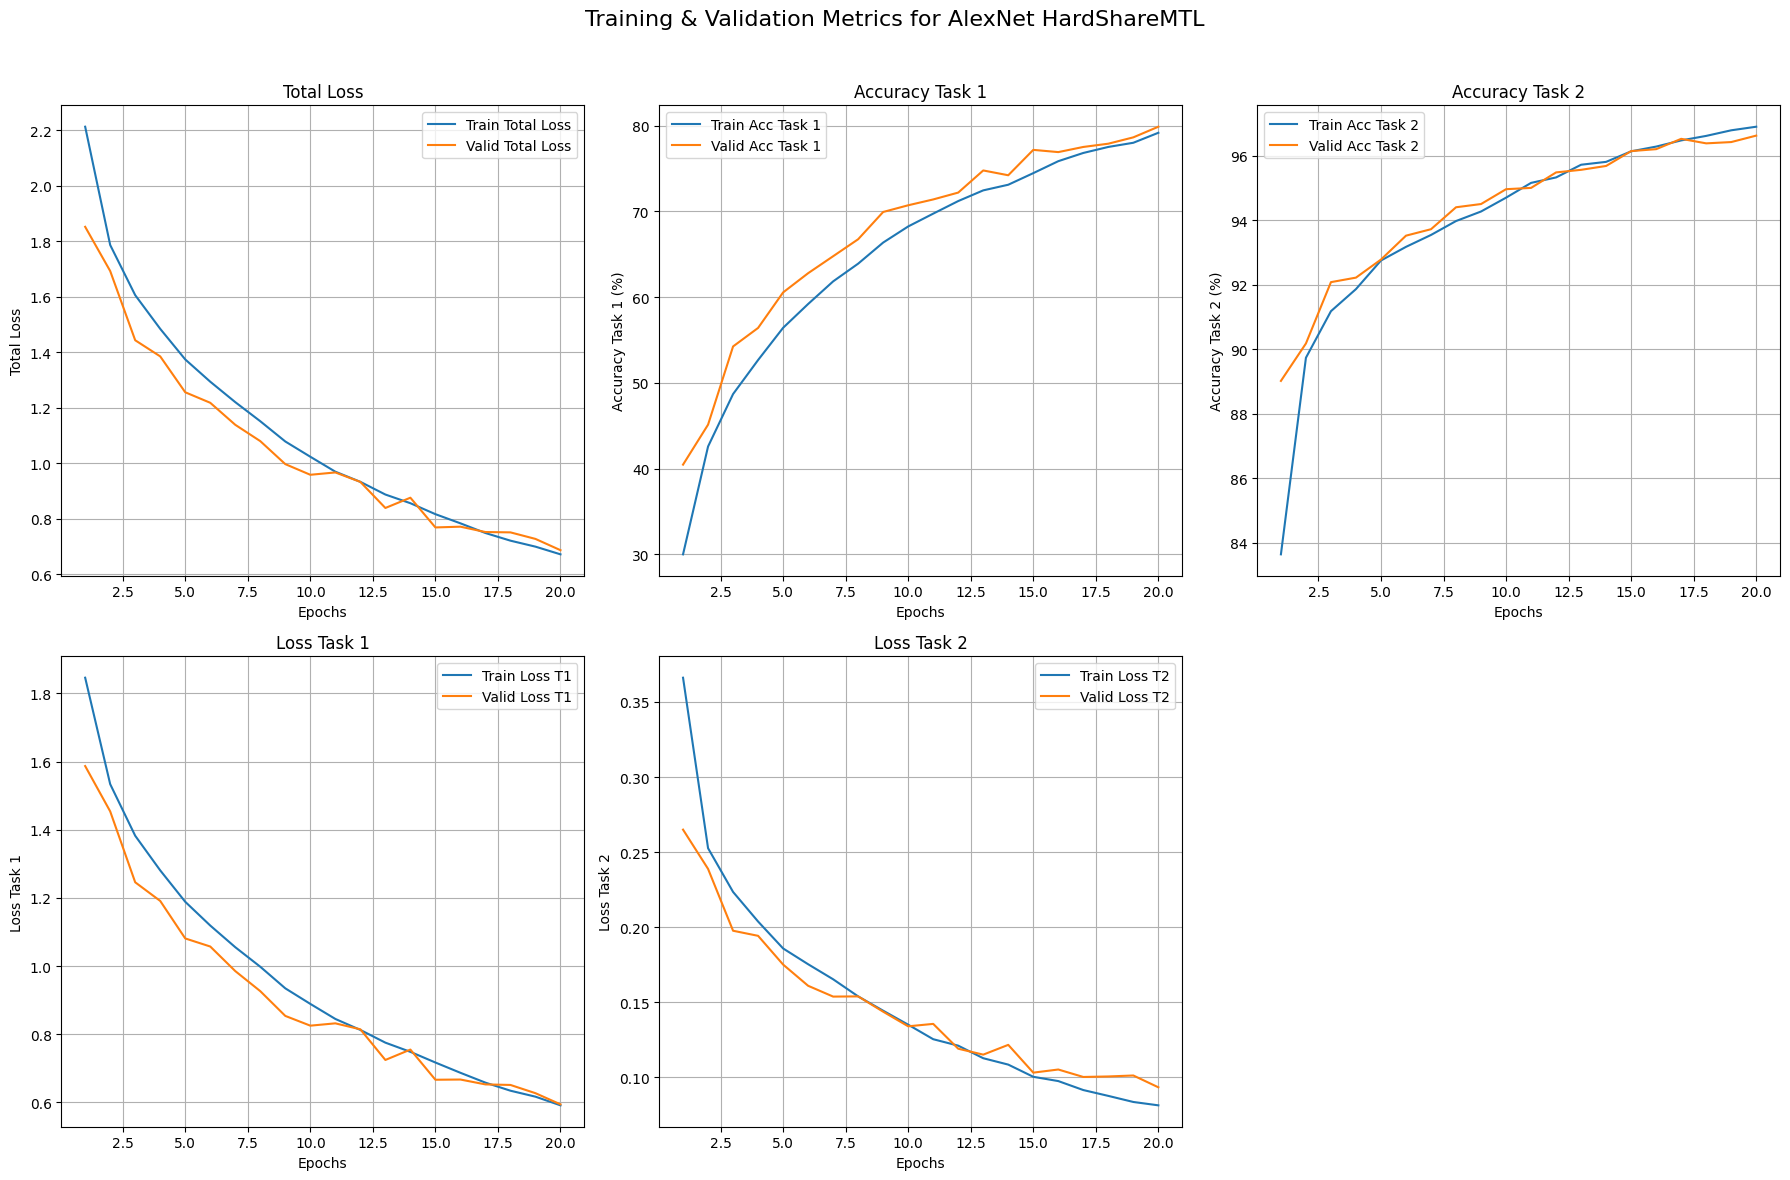

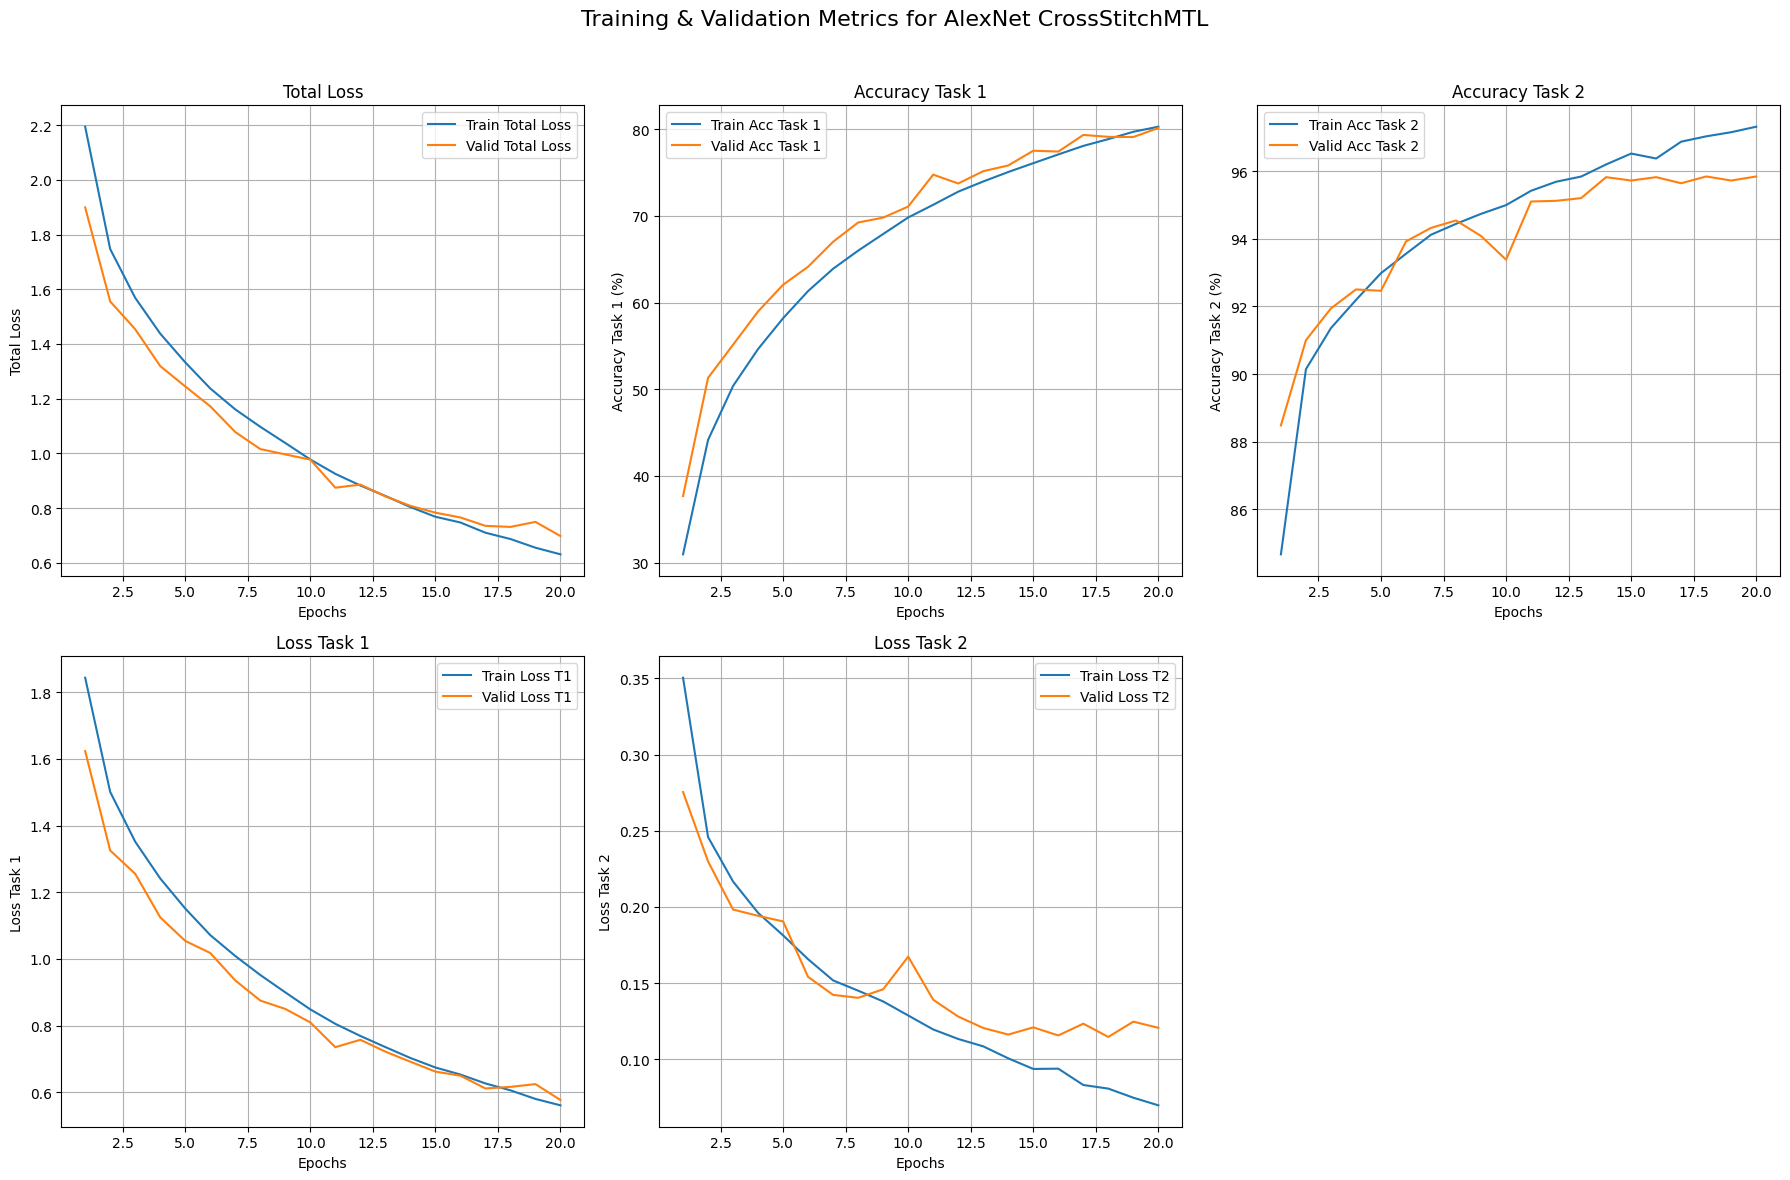

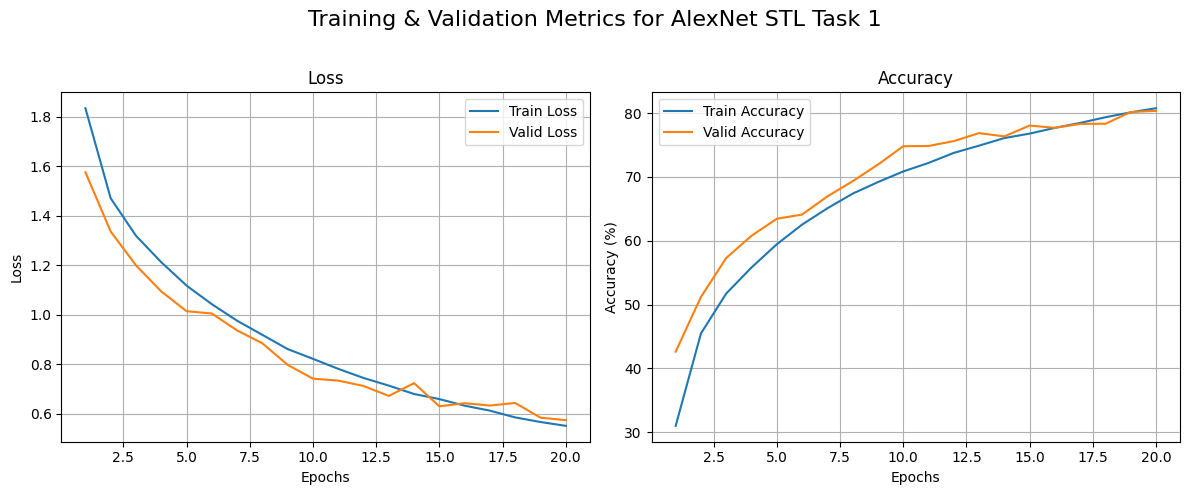

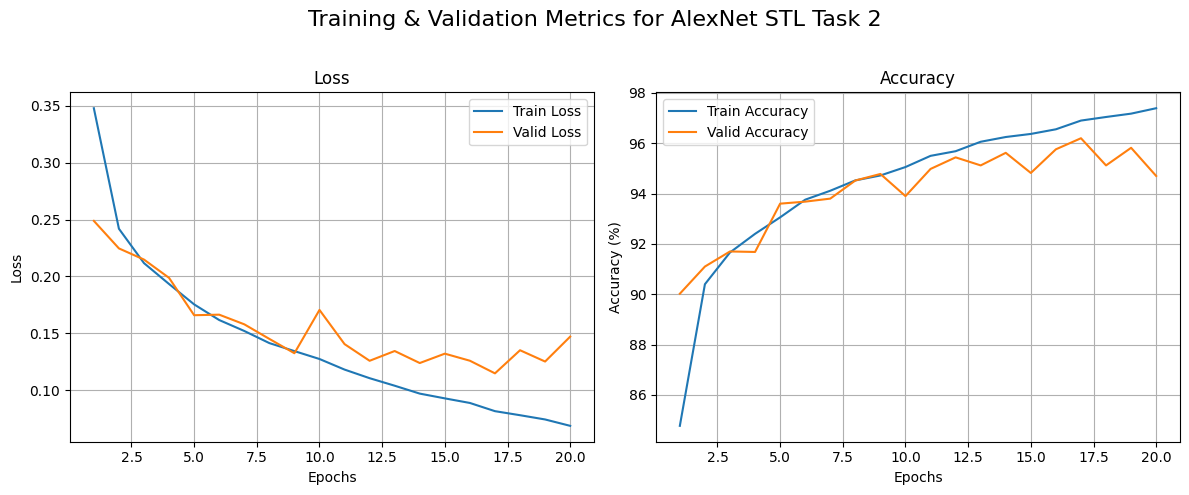

In [ ]:
# Plot results
# Ensure results lists are populated before calling plot function
if 'hs_mtl_training_results_list' in globals() and hs_mtl_training_results_list:
   plot_training_results(hs_mtl_training_results_list, "AlexNet HardShareMTL")
else:
    print("HardShareMTL results not available for plotting.")

if 'cs_mtl_training_results_list' in globals() and cs_mtl_training_results_list:
   plot_training_results(cs_mtl_training_results_list, "AlexNet CrossStitchMTL")
else:
    print("CrossStitchMTL results not available for plotting.")

if 'stl_task1_training_results_list' in globals() and stl_task1_training_results_list:
   plot_training_results(stl_task1_training_results_list, "AlexNet STL Task 1")
else:
    print("STL Task 1 results not available for plotting.")

if 'stl_task2_training_results_list' in globals() and stl_task2_training_results_list:
   plot_training_results(stl_task2_training_results_list, "AlexNet STL Task 2")
else:
    print("STL Task 2 results not available for plotting.")

In [ ]:
# Final Performance Summary
print("\n--- Performance Summary (Final Test Set Accuracies) ---")
# Check if final accuracy variables exist before printing
if 'final_test_acc1_hs_mtl' in globals():
    print(f"AlexNet HardShareMTL - Task 1 Acc: {final_test_acc1_hs_mtl:.2f}%, Task 2 Acc: {final_test_acc2_hs_mtl:.2f}%")
else:
    print("HardShareMTL final test accuracies not available.")

if 'final_test_acc1_cs_mtl' in globals():
    print(f"AlexNet CrossStitchMTL - Task 1 Acc: {final_test_acc1_cs_mtl:.2f}%, Task 2 Acc: {final_test_acc2_cs_mtl:.2f}%")
else:
    print("CrossStitchMTL final test accuracies not available.")

if 'final_test_acc_st1' in globals():
    print(f"AlexNet STL Task 1 - Task 1 Acc: {final_test_acc_st1:.2f}%")
else:
    print("STL Task 1 final test accuracy not available.")

if 'final_test_acc_st2' in globals():
    print(f"AlexNet STL Task 2 - Task 2 Acc: {final_test_acc_st2:.2f}%")
else:
    print("STL Task 2 final test accuracy not available.")


--- Performance Summary (Final Test Set Accuracies) ---
AlexNet HardShareMTL - Task 1 Acc: 79.22%, Task 2 Acc: 96.71%
AlexNet CrossStitchMTL - Task 1 Acc: 79.85%, Task 2 Acc: 95.56%
AlexNet STL Task 1 - Task 1 Acc: 80.56%
AlexNet STL Task 2 - Task 2 Acc: 95.76%


## 11. Detailed Model Examination with Confusion Matrices

Confusion matrices help visualize the performance of a classification model by showing the counts of true positive, true negative, false positive, and false negative predictions for each class.

### 11.1. Helper Functions for Predictions and Plotting

In [ ]:
# Function to get predictions for MTL models
def get_predictions_mtl(model, dataloader, device):
    model.eval()
    all_labels_t1, all_labels_t2 = [], []
    all_preds_t1, all_preds_t2 = [], []

    with torch.no_grad():
        for images, labels_t1, labels_t2 in tqdm(dataloader, desc="Getting MTL Predictions"):
            images = images.to(device)
            # MTL model returns dummy_shared_repr, outputs_t1, outputs_t2
            outputs_t1, outputs_t2 = model(images)

            # Task 1 predictions
            _, predicted_t1 = torch.max(outputs_t1.data, 1)
            all_preds_t1.append(predicted_t1.cpu())
            all_labels_t1.append(labels_t1.cpu())

            # Task 2 predictions
            predicted_t2 = (torch.sigmoid(outputs_t2.data) > 0.5).float()
            all_preds_t2.append(predicted_t2.cpu().squeeze())
            all_labels_t2.append(labels_t2.cpu())

    return (torch.cat(all_labels_t1), torch.cat(all_preds_t1),
            torch.cat(all_labels_t2), torch.cat(all_preds_t2))

In [ ]:
# Function to get predictions for STL models
def get_predictions_stl(model, dataloader, device, task_id):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels_t1, labels_t2 in tqdm(dataloader, desc=f"Getting STL Predictions ({task_id})"):
            images = images.to(device)
            targets = labels_t1 if task_id == "task1" else labels_t2

            outputs = model(images)

            if task_id == "task1":
                _, predicted = torch.max(outputs.data, 1)
            else: # Task 2
                predicted = (torch.sigmoid(outputs.data) > 0.5).float().squeeze()

            all_preds.append(predicted.cpu())
            all_labels.append(targets.cpu())

    return torch.cat(all_labels), torch.cat(all_preds)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix_custom(true_labels, pred_labels, class_names, title_suffix=""):
    cm = confusion_matrix(true_labels.numpy(), pred_labels.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6) if len(class_names) > 2 else (5,4))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {title_suffix}')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

### 11.2. Confusion Matrices for AlexNetMTL_HardShare

Getting MTL Predictions: 100%|██████████| 79/79 [00:03<00:00, 22.82it/s]


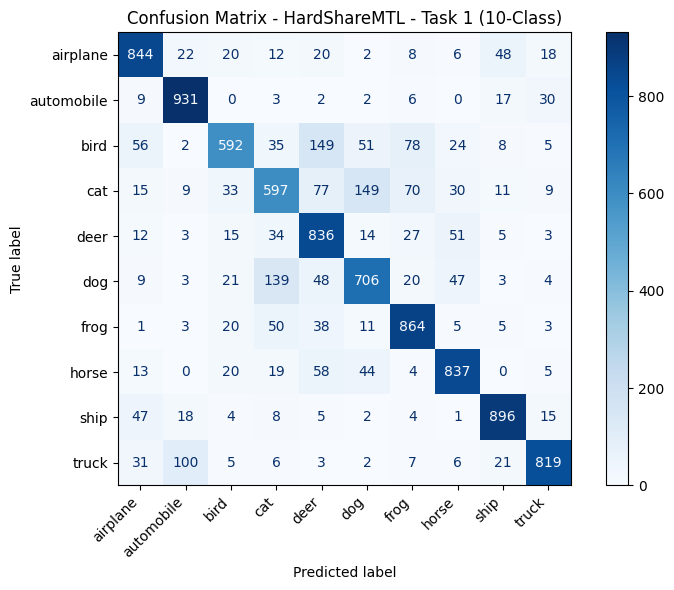

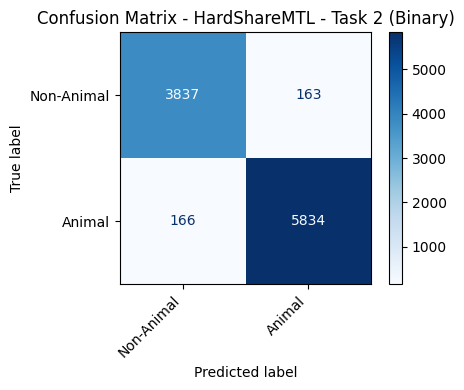

In [ ]:
# Get predictions for the best Hard-Share MTL model
hs_mtl_true_l1, hs_mtl_pred_l1, hs_mtl_true_l2, hs_mtl_pred_l2 = get_predictions_mtl(model_hard_share_mtl, test_loader, device)

classes_task1 = testset_transformed.classes

# Plot confusion matrix for Task 1 (Hard-Share MTL)
plot_confusion_matrix_custom(hs_mtl_true_l1, hs_mtl_pred_l1, classes_task1, title_suffix="HardShareMTL - Task 1 (10-Class)")

classes_task2 = ["Non-Animal", "Animal"]

# Plot confusion matrix for Task 2 (Hard-Share MTL)
plot_confusion_matrix_custom(hs_mtl_true_l2, hs_mtl_pred_l2, classes_task2, title_suffix="HardShareMTL - Task 2 (Binary)")


### 11.3. Confusion Matrices for CrossStitchAlexNetMTL

Getting MTL Predictions: 100%|██████████| 79/79 [00:03<00:00, 21.51it/s]


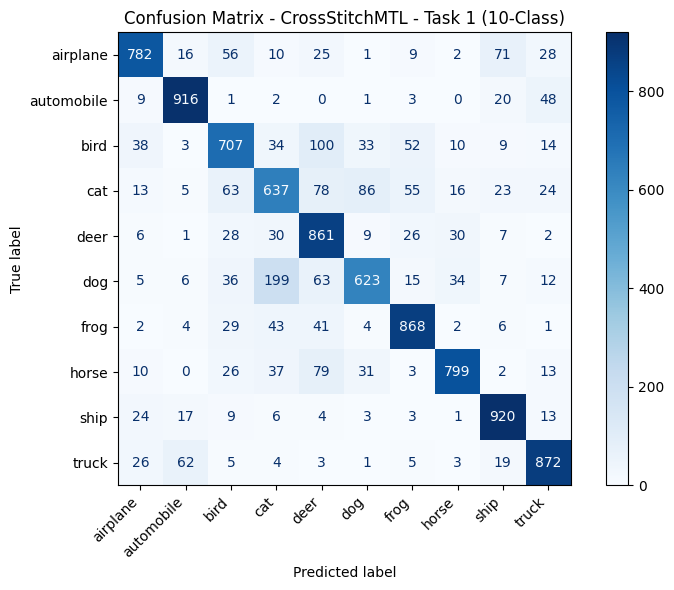

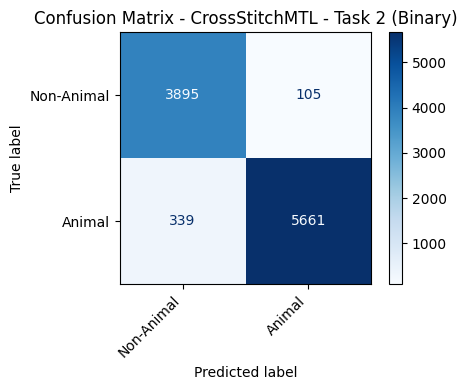

In [ ]:
# Get predictions for the best Cross-Stitch MTL model
cs_mtl_true_l1, cs_mtl_pred_l1, cs_mtl_true_l2, cs_mtl_pred_l2 = get_predictions_mtl(model_cross_stitch_mtl, test_loader, device)

# Plot confusion matrix for Task 1 (Cross-Stitch MTL)
plot_confusion_matrix_custom(cs_mtl_true_l1, cs_mtl_pred_l1, classes_task1, title_suffix="CrossStitchMTL - Task 1 (10-Class)")

# Plot confusion matrix for Task 2 (Cross-Stitch MTL)
plot_confusion_matrix_custom(cs_mtl_true_l2, cs_mtl_pred_l2, classes_task2, title_suffix="CrossStitchMTL - Task 2 (Binary)")


### 11.4. Confusion Matrix for AlexNetSTL - Task 1

Getting STL Predictions (task1): 100%|██████████| 79/79 [00:02<00:00, 26.65it/s]


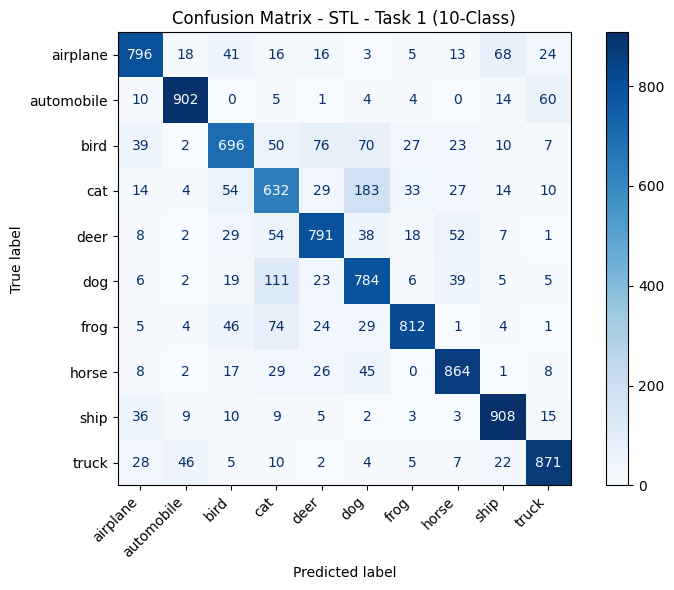

In [ ]:
# Get predictions for the best STL Task 1 model
stl_t1_true_l, stl_t1_pred_l = get_predictions_stl(model_stl_task1, test_loader, device, "task1")
plot_confusion_matrix_custom(stl_t1_true_l, stl_t1_pred_l, classes_task1, title_suffix="STL - Task 1 (10-Class)")


### 11.5. Confusion Matrix for AlexNetSTL - Task 2

Getting STL Predictions (task2): 100%|██████████| 79/79 [00:03<00:00, 22.74it/s]


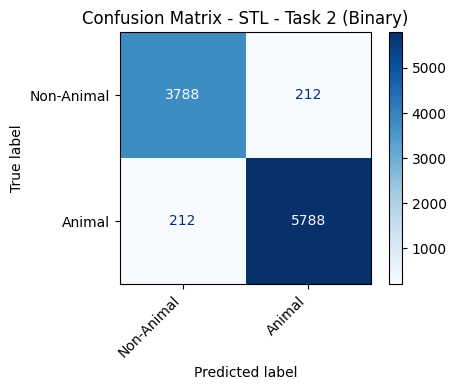

In [ ]:
# Get predictions for the best STL Task 2 model
stl_t2_true_l, stl_t2_pred_l = get_predictions_stl(model_stl_task2, test_loader, device, "task2")
plot_confusion_matrix_custom(stl_t2_true_l, stl_t2_pred_l, classes_task2, title_suffix="STL - Task 2 (Binary)")
